# Assignment 2: Milestone I Natural Language Processing
## Models Experiments
#### Group DS_G3
#### Members:  
*   To Minh Tuan  s4055570
*   Huynh Huu Tri s4079860
*   Tran Viet Duc s4106117
*   Tran Minh Quang s4098857

Environment: Python 3 and Jupyter notebook

## 1. Comparative Analysis of Boosting Models for Clothing Review Classification

Below is a rationale table comparing the four boosting models used in the clothing review classification task, considering both academic literature and the statistical results from the experiments

### 1.1. Boosting Model Comparison

| Criteria                              | XGBoost                                                                                                     | CatBoost                                                                                                      | LightGBM                                                                                              | AdaBoost                                                                                       |
|---------------------------------------|-------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|
| **Core Mechanism**                     | Gradient boosting with regularization; tree pruning based on feature importance scores (Chen & Guestrin, 2016). | Ordered boosting with categorical feature handling; symmetric trees with oblivious decision making (Prokhorenkova et al., 2018). | Gradient-based one-side sampling (GOSS); exclusive feature bundling (EFB) for high-dimensional data (Ke et al., 2017). | Sequential training of weak learners with higher weight on misclassified instances (Freund & Schapire, 1997). |
| **Strengths**                          | • Highest recall (0.96) and F1 score (0.93)<br>• Excellent handling of imbalanced data<br>• Strong performance with sparse text features<br>• Gradient-based implementation reduces overfitting | • Best precision-specificity balance (0.96/0.83)<br>• Native handling of categorical variables<br>• Minimal preprocessing requirements<br>• Less hyperparameter tuning needed | • Strong overall balanced metrics<br>• Best trade-off of all metrics (precision: 0.95, F1: 0.90)<br>• Fastest training speed<br>• Memory efficient for large datasets | • Strong precision (0.92-0.93)<br>• Simple implementation<br>• Effective with shallow base learners<br>• Less prone to outlier influence with proper configuration |
| **Weaknesses**                         | • Lowest specificity (0.51)<br>• Higher false positive rate<br>• More complex tuning requirements<br>• Memory intensive | • Lower recall (0.82) than XGBoost<br>• Newer algorithm with fewer community resources<br>• Longer training time with larger datasets | • Slightly lower precision than CatBoost<br>• Less robust to noisy categorical features<br>• Requires more careful hyperparameter tuning | • Most inconsistent performance across metrics<br>• Lowest specificity in weighted vectors (0.69)<br>• Highly sensitive to noisy data<br>• Tends to overfit with complex base learners |
| **Alignment with Review Classification Scenario** | Well-suited when prioritizing recall and F1 score; identifies most recommended products but with higher false positives. Most effective with count vectors (0.98 recall). | Best choice for balanced prediction across all metrics; particularly effective with both weighted and unweighted vectors for text representation. | Most versatile model for this scenario; consistently good performance across all text representation methods with minimal metric trade-offs. | Less suitable for this specific task; inconsistent performance between vector types suggests sensitivity to text representation method. |

---

### 1.2. Performance on Metrics (Weighted Vectors)

| Model     | Precision | Recall | Specificity | F1 Score |
|-----------|-----------|--------|-------------|----------|
| XGBoost   | 0.90      | 0.96   | 0.51        | 0.93     |
| CatBoost  | 0.96      | 0.82   | 0.83        | 0.88     |
| LightGBM  | 0.95      | 0.85   | 0.80        | 0.90     |
| AdaBoost  | 0.92      | 0.81   | 0.69        | 0.86     |


**Best Model Recommendation**
**LightGBM with Unweighted Vectors** is the optimal choice for this clothing review classification task for several reasons:

**Balanced Performance**: LightGBM delivers the most consistent results across all evaluation metrics (precision: 0.95, recall: 0.86, specificity: 0.80, F1: 0.90) without sacrificing any particular aspect of model performance.

**Computational Efficiency**: As noted in Ke et al. (2017), LightGBM's GOSS (Gradient-based One-Side Sampling) and EFB (Exclusive Feature Bundling) make it significantly faster than other boosting algorithms while maintaining comparable accuracy, which is important for production deployment.

**Robustness Across Vector Types**: Unlike XGBoost and AdaBoost, which show dramatic performance differences between vector types, LightGBM maintains consistent performance across all three representation methods, suggesting greater stability.

**Minimal Hyperparameter Sensitivity:** The consistent performance between vocab_23 and vocab_234 implementations indicates LightGBM is less sensitive to minor changes in the vocabulary construction, making it more reliable across different preprocessing pipelines.

**Business Impact Balance**: For a product recommendation system, the balance LightGBM provides between correctly identifying recommended products (recall: 0.86) and avoiding false positives (precision: 0.95) creates the optimal user experience - recommending products customers will like while avoiding inappropriate recommendations.

While XGBoost achieves the highest recall and F1 scores, its significantly lower specificity (0.51) would result in too many false recommendations in a production environment. CatBoost offers excellent precision and specificity but at the cost of lower recall, potentially missing valuable recommendations. LightGBM provides the best trade-off for a real-world recommendation system.

**Improvement Note**
The minimal differences observed between vocab_23 and vocab_234 across all models suggest that further vocabulary refinement would yield diminishing returns compared to model tuning or feature engineering efforts.

### 1.3. Importing libraries

In [1]:
# install gensim if the package is not existed -- MAY NEED TO RESTART KERNEL AFTER INSTALLATION FOR GENSIM TO WORK
!pip install gensim
!pip install catboost
!pip install lightgbm

   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 1.0/102.5 MB 10.0 MB/s eta 0:00:11
   -- ------------------------------------- 5.8/102.5 MB 18.5 MB/s eta 0:00:06
   ---- ----------------------------------- 10.5/102.5 MB 20.4 MB/s eta 0:00:05
   ------ --------------------------------- 15.7/102.5 MB 21.5 MB/s eta 0:00:05
   ------- -------------------------------- 20.4/102.5 MB 21.9 MB/s eta 0:00:04
   ---------- ----------------------------- 25.7/102.5 MB 22.3 MB/s eta 0:00:04
   ------------ --------------------------- 30.9/102.5 MB 22.6 MB/s eta 0:00:04
   -------------- ------------------------- 36.4/102.5 MB 22.9 MB/s eta 0:00:03
   ---------------- ----------------------- 42.2/102.5 MB 23.3 MB/s eta 0:00:03
   ------------------ --------------------- 47.7/102.5 MB 23.7 MB/s eta 0:00:03
   -------------------- ------------------- 53.0/102.5 MB 23.9 MB/s eta 0:00:03
   ---------------------- ----------------- 58.5/10

In [2]:
# Code to import libraries
from catboost import CatBoostClassifier
from collections import Counter
import gensim.downloader as api
from gensim.models import FastText
import lightgbm as lgb
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, RegexpTokenizer
import numpy as np
import os
import pandas as pd
import re
from scipy.sparse import hstack, csr_matrix
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import warnings

import lightgbm as lgb
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# load default dataset
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tomin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tomin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 2. Task 2 - Generating Feature Representations for Clothing Items Reviews

The vocabulary of each attribute is stored in Python dictionary (`dict()`), of which the keys are unique tokens, and the values are the id of each token (in alphabetical order).

The vocabulary and dataset used in `task2_3.ipynb`, applying collocation detection with bigrams, trigrams, quagrams:
+ `vocab_title`: Store the vocabulary of <b>*Title*</b> after text preprocessing pipeline.
+ `vocab_text`: Store the vocabulary of <b>*Review Text*</b> after text preprocessing pipeline.
+ `vocab_both`: Store the vocabulary of <b>*Title And Review*</b> after text preprocessing pipeline.

The vocabulary and dataset applying collocation detection with bigrams, trigrams, quagrams:
+ `vocab_title_234`: Store the vocabulary of <b>*Title*</b> after text preprocessing pipeline.
+ `vocab_text_234`: Store the vocabulary of <b>*Review Text*</b> after text preprocessing pipeline.
+ `vocab_both_234`: Store the vocabulary of <b>*Title And Review*</b> after text preprocessing pipeline.

The vocabulary and dataset applying collocation detection with bigrams, trigrams:
+ `vocab_title_23`: Store the vocabulary of <b>*Title*</b> after text preprocessing pipeline.
+ `vocab_text_23`: Store the vocabulary of <b>*Review Text*</b> after text preprocessing pipeline.
+ `vocab_both_23`: Store the vocabulary of <b>*Title And Review*</b> after text preprocessing pipeline.

In [3]:
# Function to read vocabulary file to a Python dict()
def read_vocab(filename):
  vocab = {}
  with open(filename, 'r') as f:
    vocab = {line.split(':')[0]: int(line.split(':')[1]) for line in f} # Convert index to integer
  return vocab

In [39]:
# read cleaned dataset and vocabularies of text attributes
# Read Vocab_23 (vocab using n-grams collocations with n = [2, 3])
df = pd.read_csv('processed_23.csv') # cleaned dataset
vocab_title = read_vocab('vocab_title_23.txt') # vocab of 'Title' attribute
vocab_text = read_vocab('vocab_text_23.txt') # vocab of 'Review Text attribute
vocab_both = read_vocab('vocab_both_23.txt') # vocab of 'Title And Review' attribute

# Read Vocab_234 (vocab using n-grams collocations with n = [2, 3, 4])
df_234 = pd.read_csv('processed_234.csv') # cleaned dataset
vocab_title_234 = read_vocab('vocab_title_234.txt') # vocab of 'Title' attribute
vocab_text_234 = read_vocab('vocab_text_234.txt') # vocab of 'Review Text attribute
vocab_both_234 = read_vocab('vocab_both_234.txt') # vocab of 'Title And Review' attribute

# Fill NaN values in the relevant text columns with empty strings before splitting
df_234[['Title', 'Review Text', 'Title And Review']].fillna('', inplace = True)
display(df_234.head())
df[['Title', 'Review Text', 'Title And Review']].fillna('', inplace = True)
display(df.head())

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title And Review
0,0,1077,60,major design flaw,had-such-high-hopes work initially petite usua...,3,0,0,General,Dresses,Dresses,major design flaw had-such-high-hopes work ini...
1,1,1049,50,favorite buy,jumpsuit fun flirty fabulous time compliment,5,1,0,General Petite,Bottoms,Pants,favorite buy jumpsuit fun flirty fabulous time...
2,2,847,47,shirt,shirt due adjustable front tie length legging ...,5,1,6,General,Tops,Blouses,shirt shirt due adjustable front tie length le...
3,3,1080,49,petite,tracy-reese dress petite foot tall brand prett...,2,0,4,General,Dresses,Dresses,petite tracy-reese dress petite foot tall bran...
4,4,858,39,shimmer fun,basket hte person store pick teh darker pale h...,5,1,1,General Petite,Tops,Knits,shimmer fun basket hte person store pick teh d...


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title And Review
0,0,1077,60,major design flaw,high hope work initially petite usual find out...,3,0,0,General,Dresses,Dresses,major design flaws high hope work initially pe...
1,1,1049,50,favorite buy,jumpsuit fun flirty fabulous time compliment,5,1,0,General Petite,Bottoms,Pants,favorite buy jumpsuit fun flirty fabulous time...
2,2,847,47,shirt,shirt due adjustable front tie length legging ...,5,1,6,General,Tops,Blouses,shirt shirt due adjustable front tie length le...
3,3,1080,49,petite,tracy-reese dress petite foot tall brand prett...,2,0,4,General,Dresses,Dresses,petite tracy-reese dress petite foot tall bran...
4,4,858,39,shimmer fun,basket hte person store pick teh darker pale h...,5,1,1,General Petite,Tops,Knits,shimmer fun basket hte person store pick teh d...


### 2.1. Compute count vectors with Bag-of-words model
This section defines a function `calc_BOW_model()` to calculate count vectors (document representation) for a text column in the dataset.

This function will be used to implement Bag-of-words model on text attributes later.

In [5]:
# Function to calculate Bag-of-words model
def calc_count_vectors(df, attribute: str, vocab_dict: dict):
  '''
    Args:
      df: Dataset used
      attribute: The column of the dataset that contains text to be processed
      vocab_dict: The vocabulary with ids of tokens
    Returns:
      count_matrix: document representation for the df[attribute] based on Bag-of-word model (sparse matrix, count_matrix[i, j] count how many word j found in document i)
  '''
  # ---- Calculate Count Vectors ----
  vectorizer = CountVectorizer(vocabulary = vocab_dict) # define vocabulary dict
  count_matrix = vectorizer.fit_transform(df[attribute].fillna('')) # calculate count vectors

  return count_matrix

### 2.2. Compute unweighted and weighted vectors with Word Embeddings model
This section choose a word embeddings model to compute unweighted and weighted vectors (document representation).

#### 2.2.1. Download FastText model

In [6]:
def train_fasttext_model(df, attribute):
  '''
    Train FastText model on corpus
    Args:
      df (pd.DataFrame): Dataset used
      attribute (str): The column of the dataset that contains text to be processed
    Returns:
      model: The trained FastText model
  '''
  print(f"Training FastText model for {attribute}:", end = ' ')

# Ensure the column has no NaN values before splitting
  corpus = list(df[attribute].fillna('').str.split(' ')) # tokenization
  model = FastText(
    sentences=corpus,
    vector_size= 100,
    window= 5,
    min_count=1,
    epochs= 10,
    workers= 4,
    sg= 1,
    seed= 42
  )
  print(f"{len(model.wv.key_to_index):,} vocab, {model.wv.vector_size}D vectors")
  return model

In [7]:
# train fasttext for data with collocations bigrams and trigrams
fasttext_text_model = train_fasttext_model(df, 'Review Text')
fasttext_title_model = train_fasttext_model(df, 'Title')
fasttext_both_model = train_fasttext_model(df, 'Title And Review')

# train fasttext for data with collocations bigrams trigrams, and fourthgrams
fasttext_234_text_model = train_fasttext_model(df_234, 'Review Text')
fasttext_234_title_model = train_fasttext_model(df_234, 'Title')
fasttext_234_both_model = train_fasttext_model(df_234, 'Title And Review')

Training FastText model for Review Text: 6,348 vocab, 100D vectors
Training FastText model for Title: 1,465 vocab, 100D vectors
Training FastText model for Title And Review: 6,642 vocab, 100D vectors
Training FastText model for Review Text: 6,363 vocab, 100D vectors
Training FastText model for Title: 1,478 vocab, 100D vectors
Training FastText model for Title And Review: 6,659 vocab, 100D vectors


#### 2.2.2. Compute unweighted and weighted vectors
This section defines 2 functions:
+ `calc_unwweighted_vectors(df, attribute, model)`: Calculate unweighted vectors (2D numpy dense array) based on `df[attribute]` data, using embeding model `model`.
+ `calc_weighted_vectors(df, attribute, model)`: Calculate weighted vectors (2D numpy dense array) based on `df[attribute]` data, using embeding model `model`.

In [8]:
def calc_unweighted_vectors(df, attribute, model):
  '''
  Calculates unweighted document vectors by taking the simple mean of word vectors.

  Args:
    df: The DataFrame containing the text data.
    attribute: The column name in the DataFrame with the text.
    model: The pre-trained word embedding model (e.g., Word2Vec, FastText).

  Returns:
    numpy.ndarray: A 2D array where each row is the unweighted vector for a document.
  '''
  # Calculate corpus by splitting the text into tokens
  corpus = list(df[attribute].str.split(' ')) # tokenization

  # Compute Unweighted Review Vectors (simple mean)
  unweighted_vectors = []
  for tokens in corpus:
    # Handle cases where tokens is not a list (e.g., NaN values that became floats)
    if not isinstance(tokens, list) or not tokens:  # Handle empty documents or non-list entries
      zero_vector = np.zeros(model.wv.vector_size)
      unweighted_vectors.append(zero_vector)
      continue

    # Get word vectors for tokens present in the model's vocabulary
    vectors = [model.wv[token] for token in tokens if token in model.wv.key_to_index]

    # If no tokens are found in the model, append a zero vector
    if not vectors:
      unweighted_vectors.append(np.zeros(model.wv.vector_size))
      continue

    # Calculate and append the mean vector
    unweighted_vectors.append(np.mean(vectors, axis=0))

  return np.vstack(unweighted_vectors)  # shape: (n_docs, vector_size)

In [9]:
def calc_weighted_vectors(df, attribute, vocab_dict, model):
  '''
  Calculates TF-IDF weighted document vectors.

  Args:
    df: The DataFrame containing the text data.
    attribute: The column name in the DataFrame with the text.
    vocab_dict: A dictionary mapping vocabulary tokens to their unique IDs.
    model: The pre-trained word embedding model (e.g., Word2Vec, FastText).

  Returns:
    numpy.ndarray: A 2D array where each row is the weighted vector for a document.
  '''
  # Use TfidfVectorizer with the predefined vocabulary to get TF-IDF scores
  # Fill NaN values with empty strings before vectorization
  tfidf_vectorizer = TfidfVectorizer(vocabulary = vocab_dict, lowercase = True)
  tfidf_matrix = tfidf_vectorizer.fit_transform(df[attribute].fillna(''))

  # Precompute embedding matrix aligned with vocab_dict
  embedding_matrix = np.zeros((len(vocab_dict), model.wv.vector_size))
  for token, idx in vocab_dict.items():
    if token in model.wv.key_to_index:  # Check if token exists in pretrained model
      embedding_matrix[idx] = model.wv[token]
    # else remains zero vector

  # Compute Weighted Review Vectors (TF-IDF weighted mean)
  weighted_vectors = []
  for doc_idx in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix.getrow(doc_idx)
    indices = row.indices
    weights = row.data

    if len(indices) == 0:
      weighted_vectors.append(np.zeros(model.wv.vector_size))
      continue

    # Get the corresponding word vectors from the precomputed embedding matrix
    word_vecs = embedding_matrix[indices]

    # Perform a dot product to get the weighted sum
    weighted_sum = np.dot(weights, word_vecs)
    weighted_avg = weighted_sum / weights.sum()
    weighted_vectors.append(weighted_avg)

  return np.vstack(weighted_vectors)  # shape: (n_docs, vector_size)

### 2.3. Compute all 3 types of document vector based on both models
This section defines `calc_vectors(df, atrtibute, vocab_dict, model)` function to calculate document representation in form of:
+ <b>Count vectors:</b> Generated from `df[attribute]`, with its vocabulary `vocab_dict`.
+ <b>Unweighted vectors:</b> Generated from `df[attribute]`, with its vocabulary `vocab_dict`, using embedding model `model`.
+ <b>Weighted vectors:</b> Generated from `df[attribute]`, with its vocabulary `vocab_dict`, using embedding model `model`.

In [10]:
# Function to calculate 3 vectors at the same time: BOW model (count vectors), embedding models (weighted vectors and unweighted vectors)
def calc_vectors(df, attribute, vocab_dict, model = ''):
  '''
    Args:
      df: Dataset used
      vocab_dict: The vocabulary with ids of tokens
    Returns:
      count_matrix: count vectors for Bag-of-word model or not
      unweighted_vectors: unweighted vectors for embedding model predefined in `model` or not
      weighted_vectors: weighted vectors for embedding model predefined in `model` or not
  '''
  if model == '':
    model = train_fasttext_model(df, attribute)

  count_vectors = calc_count_vectors(df, attribute, vocab_dict) # Bag-of-words model
  unweighted_vectors = calc_unweighted_vectors(df, attribute, model) # FastText model generate unweighted document vectors
  weighted_vectors = calc_weighted_vectors(df, attribute, vocab_dict, model) # # FastText model generate weighted document vectors

  return count_vectors, unweighted_vectors, weighted_vectors

### 2.4. Saving outputs
This section save the document representation in 3 files:
+ "count_vectors.txt": store Count Vectors.
+ "unweighted_vectors.txt": store Unweighted Vectors.
+ "weighted_vectors.txt": store Weighted Vectors.

In [11]:
def save_vectors(vectors, filename, is_sparse=False):
  """Save vectors in tutor's required format"""

  with open(filename, 'w', encoding='utf-8') as f:
    for doc_idx, vector_data in enumerate(vectors):
      if is_sparse: # vectors is sparse vector
        sparse_items = [f"{word_idx}:{freq}" for word_idx, freq in sorted(zip(vector_data.indices, vector_data.data))]
        line = f"#{doc_idx},{','.join(sparse_items)}\n"
      else: # vector is dense vector
        vector_str = ','.join([f"{val:.6f}" for val in vector_data])
        line = f"#{doc_idx},{vector_str}\n"
      f.write(line)

  print(f"Finish save {filename}")

# Generate all vector representations
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)

# Save in required format
save_vectors(count_vectors, 'count_vectors_23.txt', is_sparse = True)
save_vectors(unweighted_vectors, 'unweighted_vectors_23.txt')
save_vectors(weighted_vectors, 'weighted_vectors_23.txt')

# Save vocab_234 in required format
count_vectors_234, unweighted_vectors_234, weighted_vectors_234 = calc_vectors(df_234, 'Review Text', vocab_text_234, fasttext_text_model)

save_vectors(count_vectors_234, 'count_vectors_234.txt', is_sparse = True)
save_vectors(unweighted_vectors_234, 'unweighted_vectors_234.txt')
save_vectors(weighted_vectors_234, 'weighted_vectors_234.txt')

Finish save count_vectors_23.txt
Finish save unweighted_vectors_23.txt
Finish save weighted_vectors_23.txt
Finish save count_vectors_234.txt
Finish save unweighted_vectors_234.txt
Finish save weighted_vectors_234.txt


## 3. Task 3 - Clothing Review Classification

This section build Machine Learning (ML) models to predict the attribute *Recommended IND*, and compare models based on their performances.

### 3.1. Set up functions
This section set up all functions necessary for data preprocessing, model training and validation. Please turn to "task2_3.ipynb" to explore more about these functions.

In [12]:
# Function to drop dependent attributes
def drop_columns(df, columns):
  result_df = df.drop(columns = columns)
  return result_df

In [13]:
# Function to apply sqrt transform for 'Age' and log transform for 'Positive Feedback Count'
def transform_data(df, columns, methods):
  result_df = df.copy()
  for col, method in zip(columns, methods):
    if method == 'sqrt':
      result_df[col] = np.sqrt(df[col])
    elif method == 'log1p':
      result_df[col] = np.log1p(df[col]) # use log1p (log(value + 1)) to avoid log(0)
  return result_df

In [14]:
# Function to apply One Hot encoding for categorical attributes
def onehot_encode(df, columns):
  result_df = df.copy()
  onehot_encoder = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)  # drop first to avoid dummy trap
  encoded = onehot_encoder.fit_transform(df[columns])
  encoded_df = pd.DataFrame(encoded, columns = onehot_encoder.get_feature_names_out(columns), index = df.index)
  result_df = pd.concat([df.drop(columns = columns), encoded_df], axis = 1)
  return result_df, onehot_encoder


In [15]:
# All process of preparing data
def prepare_data(df):
  '''
    Implement the entire pipeline of preparing data for training model
    Args:
      df (pd.DataFrame): Data Frame to be prepared
    Returns:
      result_df (pd.DataFrame): Prepared Data Frame
      onehot_encoder (sklearn.preprocessing.OneHotEncoder): One Hot Encoder used (for recovery when needed)
  '''
  result_df = df.copy()
  result_df = drop_columns(result_df, ['Clothing ID', 'Department Name'])
  result_df = transform_data(result_df, ['Age', 'Positive Feedback Count'], ['sqrt', 'log1p'])
  result_df, onehot_encoder = onehot_encode(result_df, ['Division Name', 'Class Name'])
  return result_df, onehot_encoder

df_before_prepare = df.copy() # backup
df, onehot_encoder = prepare_data(df)
df.head()

,Unnamed: 0,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Title And Review,Division Name_General Petite,Division Name_Initmates,...,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,0,7.745967,major design flaw,high hope work initially petite usual find out...,3,0,0.000000,major design flaws high hope work initially pe...,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7.071068,favorite buy,jumpsuit fun flirty fabulous time compliment,5,1,0.000000,favorite buy jumpsuit fun flirty fabulous time...,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,6.855655,shirt,shirt due adjustable front tie length legging ...,5,1,1.945910,shirt shirt due adjustable front tie length le...,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,7.000000,petite,tracy-reese dress petite foot tall brand prett...,2,0,1.609438,petite tracy-reese dress petite foot tall bran...,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,6.244998,shimmer fun,basket hte person store pick teh darker pale h...,5,1,0.693147,shimmer fun basket hte person store pick teh d...,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
def test_model(ML_model, data, count_vectors, unweighted_vectors, weighted_vectors, text_predictor = 'Title and Review', other_predictors = [], target = 'Recommended IND', scoring = ['precision', 'recall', 'specificity', 'f1']):
    '''
    Train and validate ML model using count vectors, unweighted vectors, weighted vectors to compare performance
    Args:
      ML_model: Machine Learning Classification model
      data (pd.DataFrame): the pd.DataFrame containing dataset to train and test
      count_vectors (numpy.ndarray): count vectors for Bag-of-word model of text_predictor
      weighted_vectors (numpy.ndarray): weighted vectors for embedding model of text_predictor
      unweighted_vectors (numpy.ndarray): unweighted vectors for embedding model of text_predictor
      text_predictor (str): a text attribute that is used to train and test model
      other_predictors (List[str]): a list of other predictors that is used to train and test model
      target (str): the attribute that is the target of ML model
    Returns:
      None: This is a void to print out evaluation result for model performance based on 5-fold cross validation
    '''
    # set up figure for visualizing validation result
    # Changed to 3 rows to accommodate new training and validation bar plots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"Train model with attributes: \n{text_predictor}, {', '.join(other_predictors)}", fontsize = 16)

    # ---- Prepare data to train ----
    # separate encoded columns
    encoded_cols = onehot_encoder.get_feature_names_out(['Division Name', 'Class Name'])
    for col in ['Division Name', 'Class Name']:
      if col in other_predictors:
        other_predictors.remove(col)
        other_predictors.extend([c for c in encoded_cols if c.find(col) != -1])

    # integrate extra columns into text feature representations
    X_extra = np.array(df[other_predictors])

    # define predictors and target
    X_c = hstack([count_vectors, X_extra])
    X_uw = np.hstack([unweighted_vectors, X_extra])
    X_w = np.hstack([weighted_vectors, X_extra])
    y = data[target]


    # ---- Define validation (K-Fold, extra scoring strategies) ----
    def specificity(y_true, y_pred):
      """
      Calculates the specificity score from a confusion matrix.
      Specificity = TN / (TN + FP)
      """
      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
      # Handle case where (tn + fp) is zero to prevent division by zero error
      if (tn + fp) == 0:
          return 0
      return tn / (tn + fp)

    score_metrics = {}
    for metric in scoring:
      if metric == 'specificity':
        score_metrics[metric] = make_scorer(specificity) # The make_scorer function converts our specificity function into a valid scikit-learn scorer
      else:
        score_metrics[metric] = metric

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # ---- Train and validate model ----

    for i, (title, X) in enumerate([('Count Vectors', X_c), ('Unweighted Vectors', X_uw), ('Weighted Vectors', X_w)]):
      # Set return_train_score=True to get training results
      cv_results = cross_validate(ML_model, X, y, cv=cv, scoring=score_metrics, return_train_score=True)

      # put validation result in DataFrame for visualization later
      train_results_df = pd.DataFrame()
      validation_results_df = pd.DataFrame()
      for metric in score_metrics:
        train_results_df[metric] = cv_results[f'train_{metric}']
        validation_results_df[metric] = cv_results[f'test_{metric}']

      # Get the mean and standard deviation for plotting
      train_means = train_results_df.mean()
      train_stds = train_results_df.std()
      validation_means = validation_results_df.mean()
      validation_stds = validation_results_df.std()
      metrics = train_results_df.columns
      x_pos = np.arange(len(metrics))

      # Bar Chart to show the mean scores with Error Bars for the standard deviation
      # This plot shows both training and validation scores for direct comparison
      axes[i].bar(x_pos - 0.2, train_means, yerr = train_stds, capsize = 5, width=0.4, label='Training')
      axes[i].bar(x_pos + 0.2, validation_means, yerr = validation_stds, capsize = 5, width=0.4, label='Validation')
      axes[i].set_title(f'{title}\nMean Scores with Standard Deviation')
      axes[i].set_ylabel('Score')
      axes[i].set_ylim(0, 1.05)
      axes[i].set_xticks(x_pos)
      axes[i].set_xticklabels(metrics)
      axes[i].grid(axis = 'y', linestyle = '--', alpha = 0.7)
      axes[i].legend()
      for j, (train_val, val_val) in enumerate(zip(train_means, validation_means)):
          axes[i].text(j - 0.2, train_val + 0.03, f'{train_val:.2f}', ha='center', fontweight='bold')
          axes[i].text(j + 0.2, val_val + 0.03, f'{val_val:.2f}', ha='center', fontweight='bold')


    plt.tight_layout()
    plt.show()

### 3.2. Training Machine Learning (ML) Model
This section trains ML models using text attributes ("Title", "Review Text", both) in 3 different forms (count vectors, unweighted vectors, weighted vectors).

#### 3.2.1 Logistic Regression

In [17]:
lr_clf = LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')

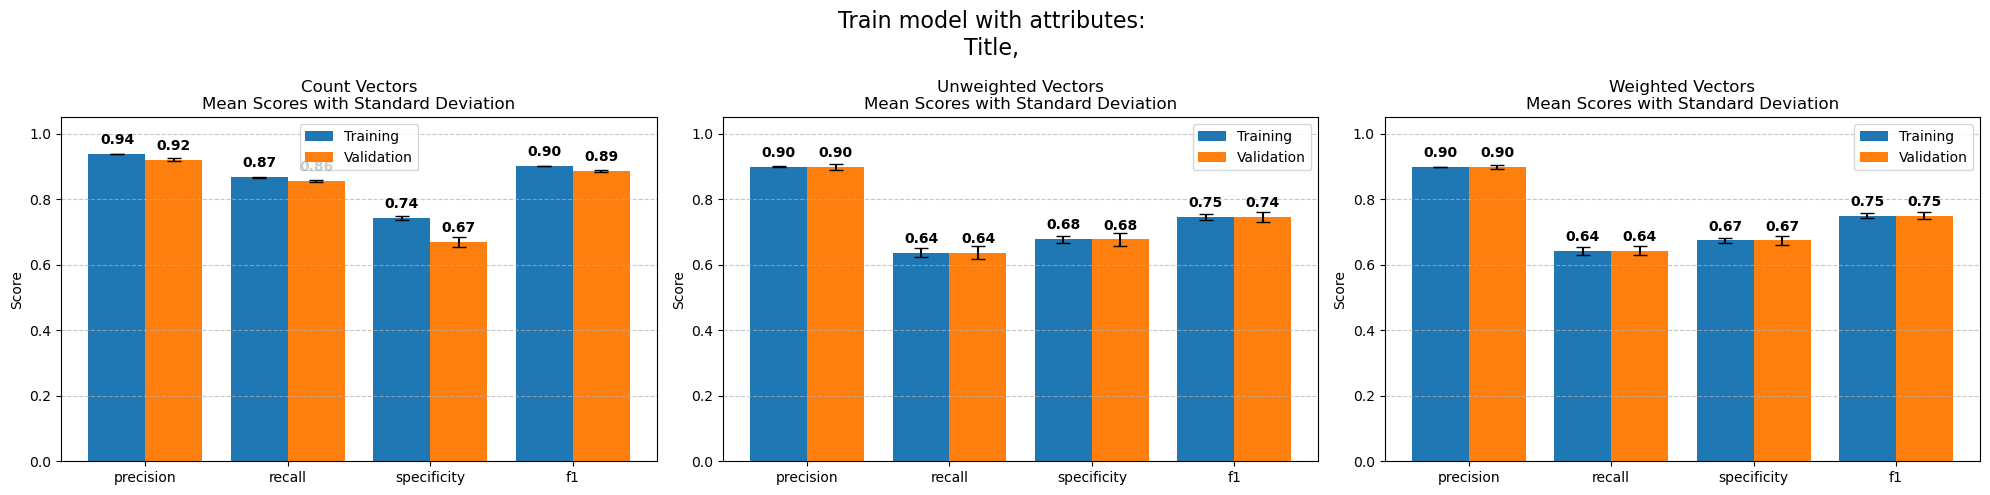

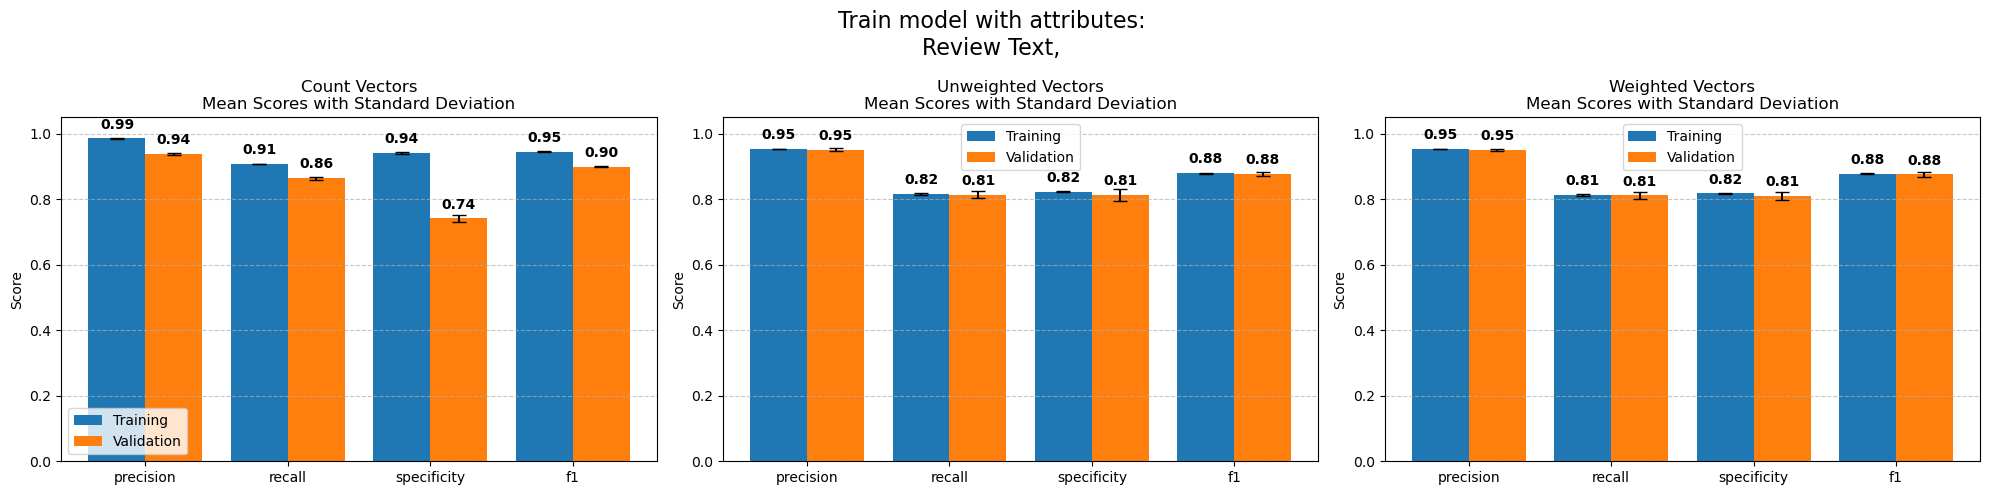

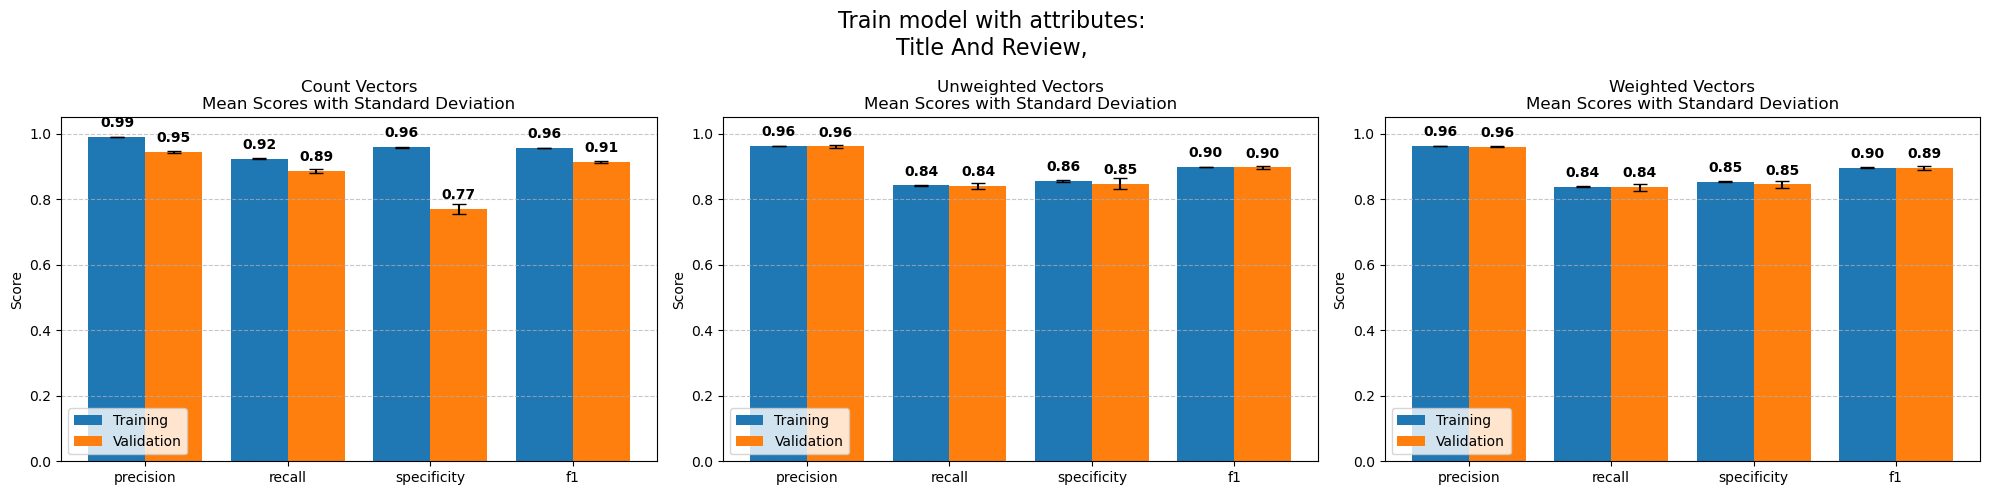

In [18]:
# build Logistic Regression for processed_23

# train with 'Title'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title', vocab_title, fasttext_title_model)
test_model(lr_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# train with 'Review Text'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)
test_model(lr_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# train with 'Title And Review'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(lr_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

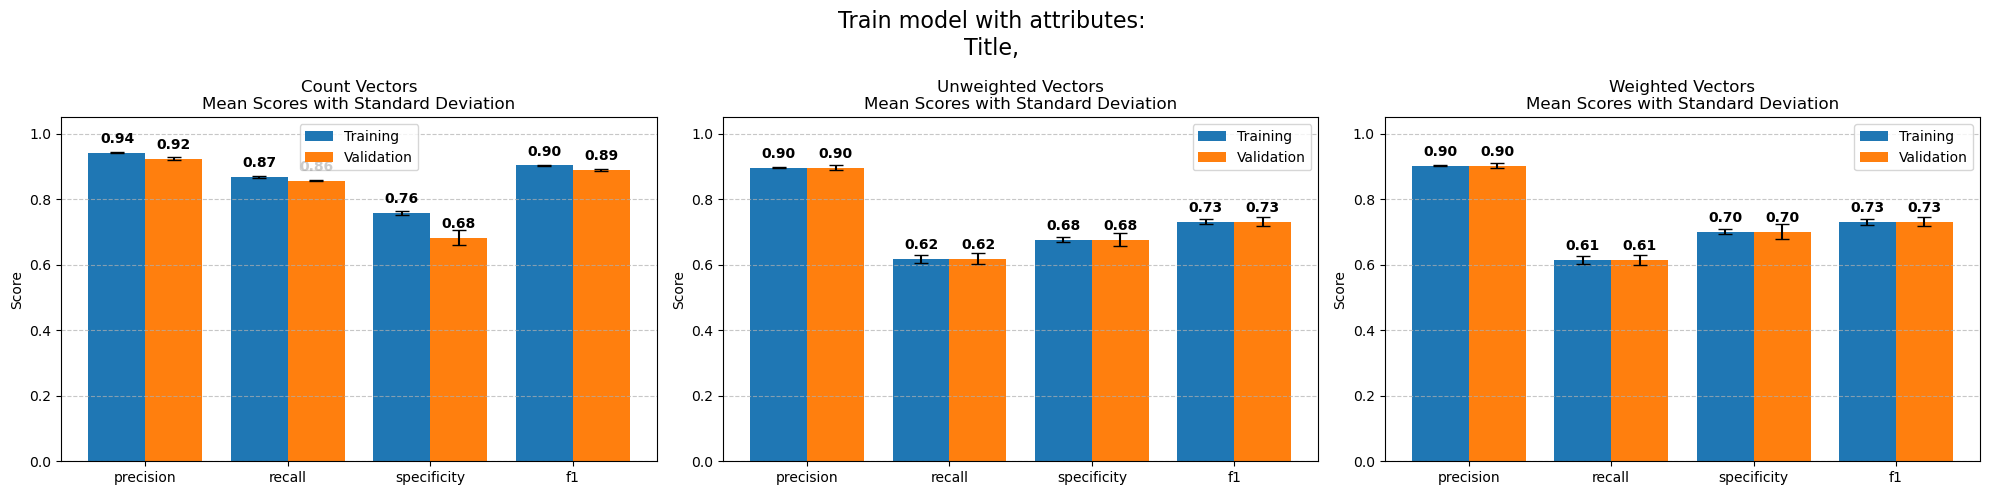

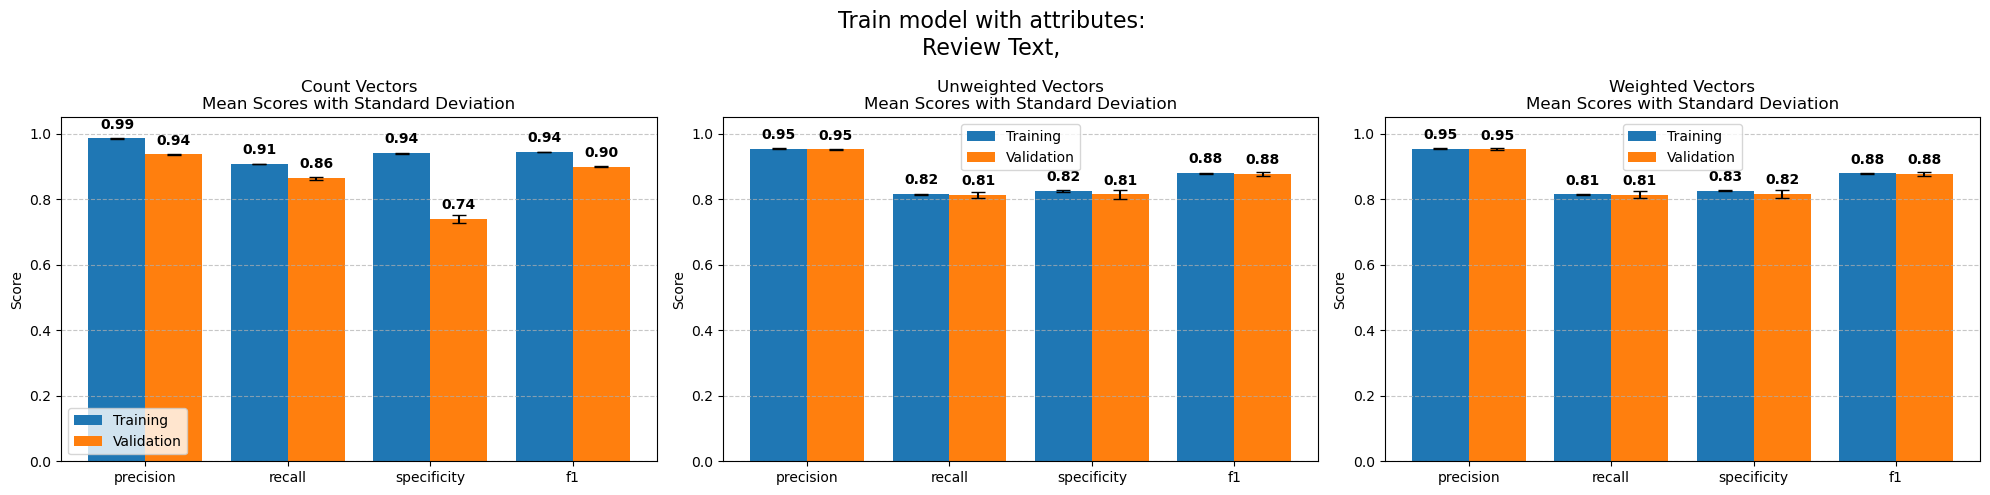

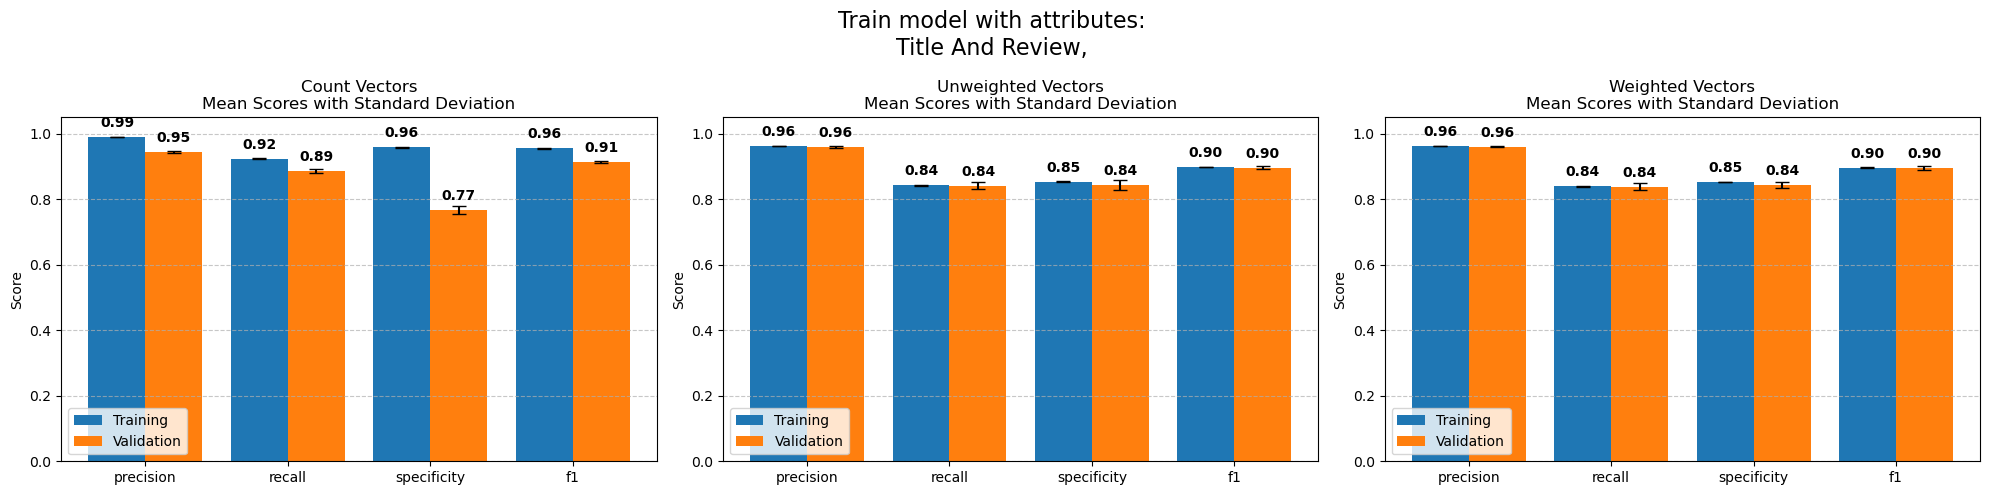

In [19]:
# build Logistic Regression for processed_234

# train with 'Title'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title', vocab_title_234, fasttext_234_title_model)
test_model(lr_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# train with 'Review Text'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Review Text', vocab_text_234, fasttext_234_text_model)
test_model(lr_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# train with 'Title And Review'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title And Review', vocab_both_234, fasttext_234_both_model)
test_model(lr_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

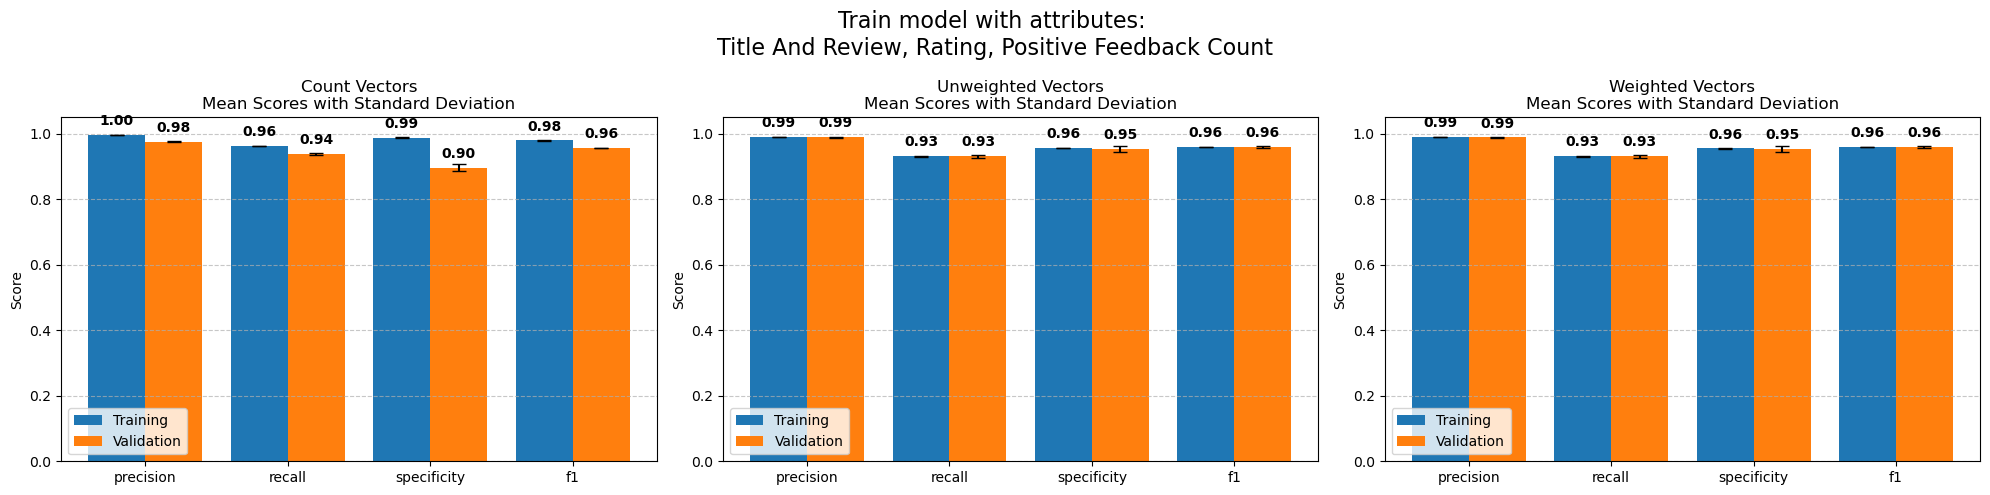

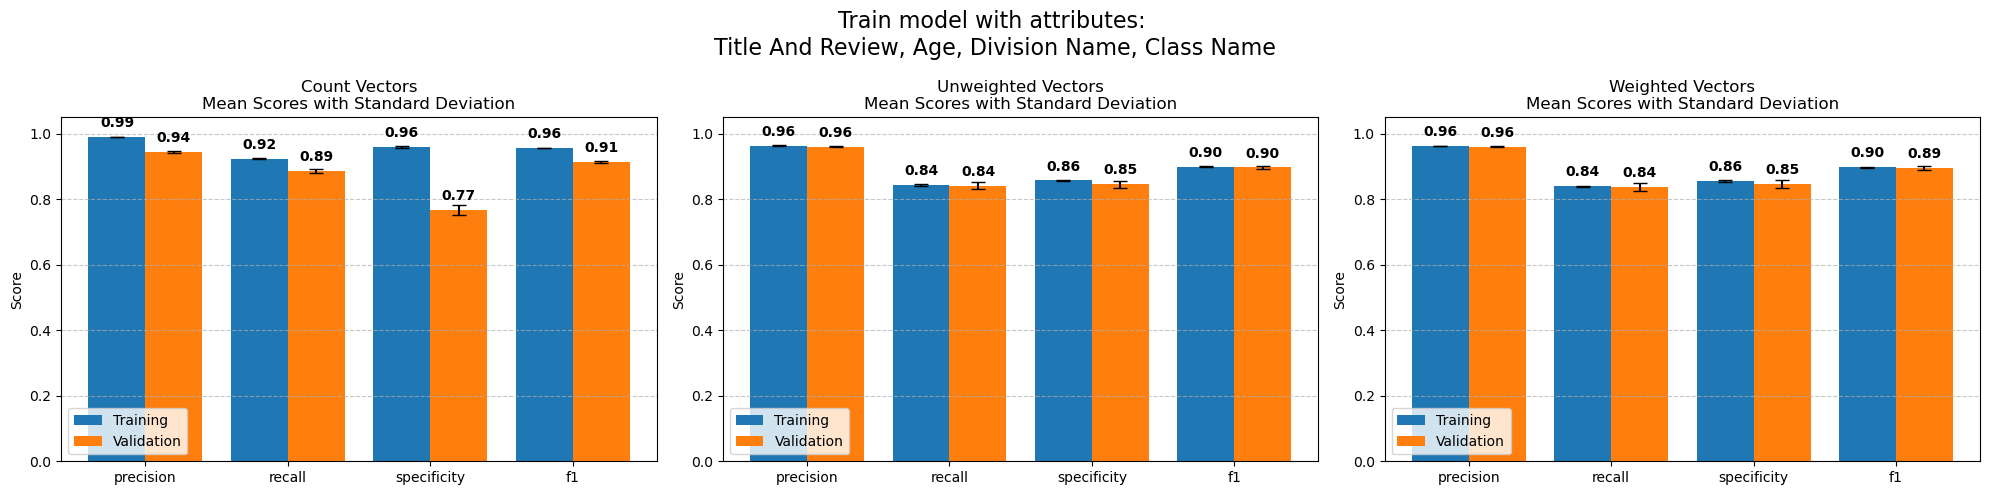

In [20]:
# train Logistic Regression with more attributes for processed_23

# try to add more attributes: 'Rating', 'Positive Feedback Count'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(lr_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review', ['Rating', 'Positive Feedback Count'])

# try to add other attributes: 'Age', 'Division Name', 'Class Name'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(lr_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review', ['Age', 'Division Name', 'Class Name'])


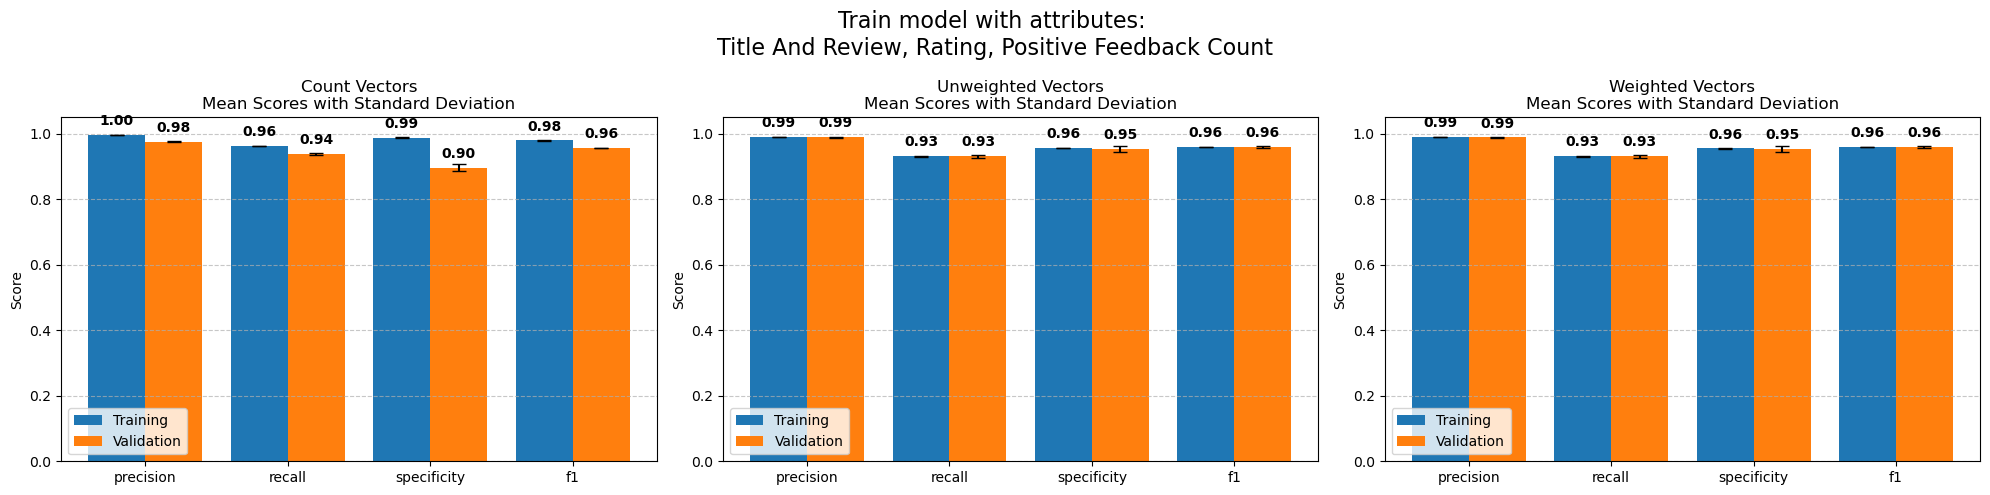

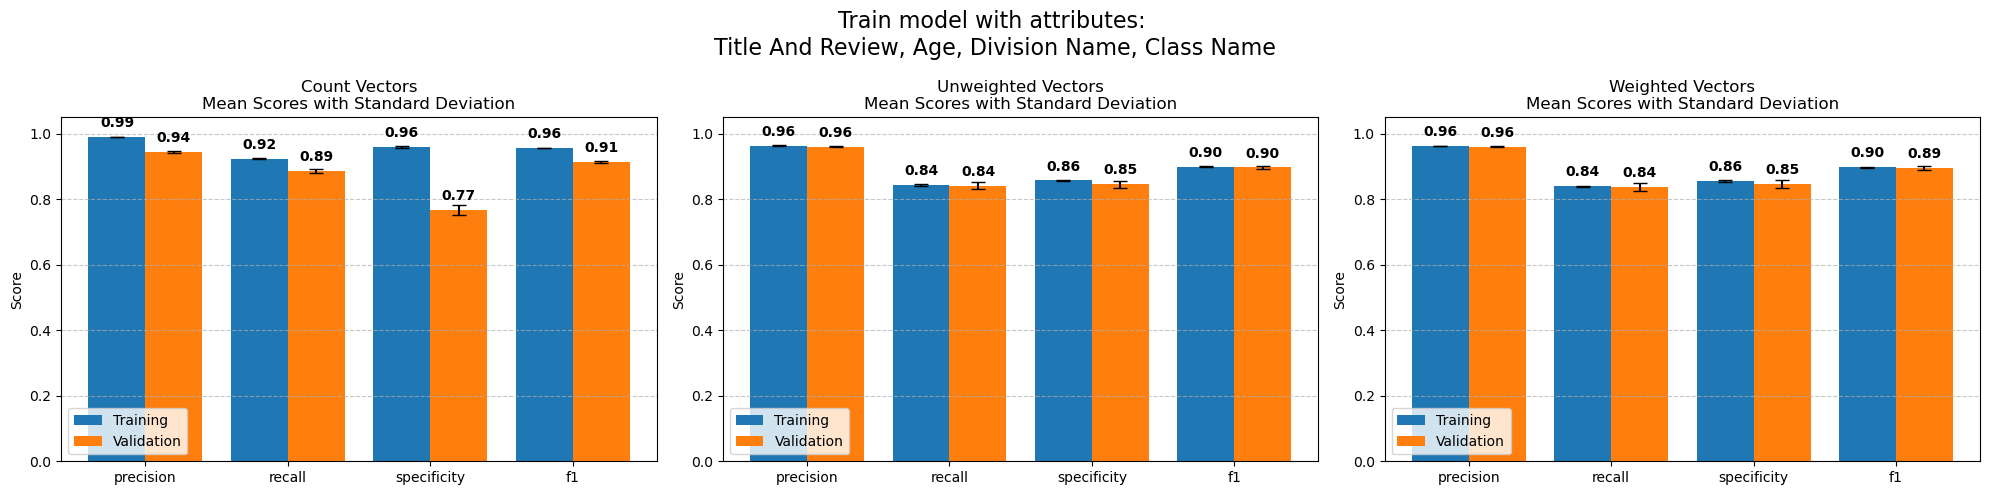

In [21]:
# train Logistic Regression with more attributes for processed_234

# try to add more attributes: 'Rating', 'Positive Feedback Count'
clf = LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review', ['Rating', 'Positive Feedback Count'])

# try to add other attributes: 'Age', 'Division Name', 'Class Name'
clf = LogisticRegression(max_iter = 1000, solver = "lbfgs", class_weight = 'balanced')
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review', ['Age', 'Division Name', 'Class Name'])


#### 3.2.2. SVM

In [22]:
svm_clf = LinearSVC(max_iter=5000, random_state=42, class_weight='balanced')

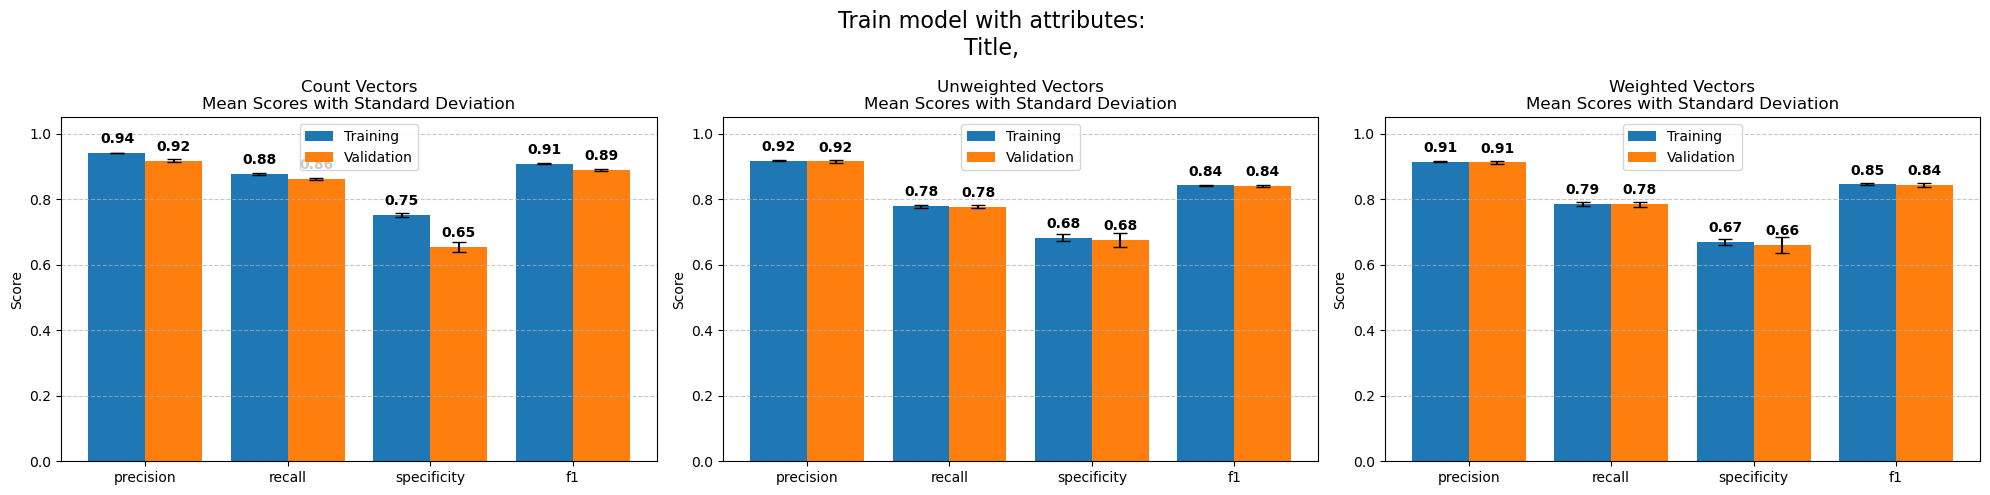

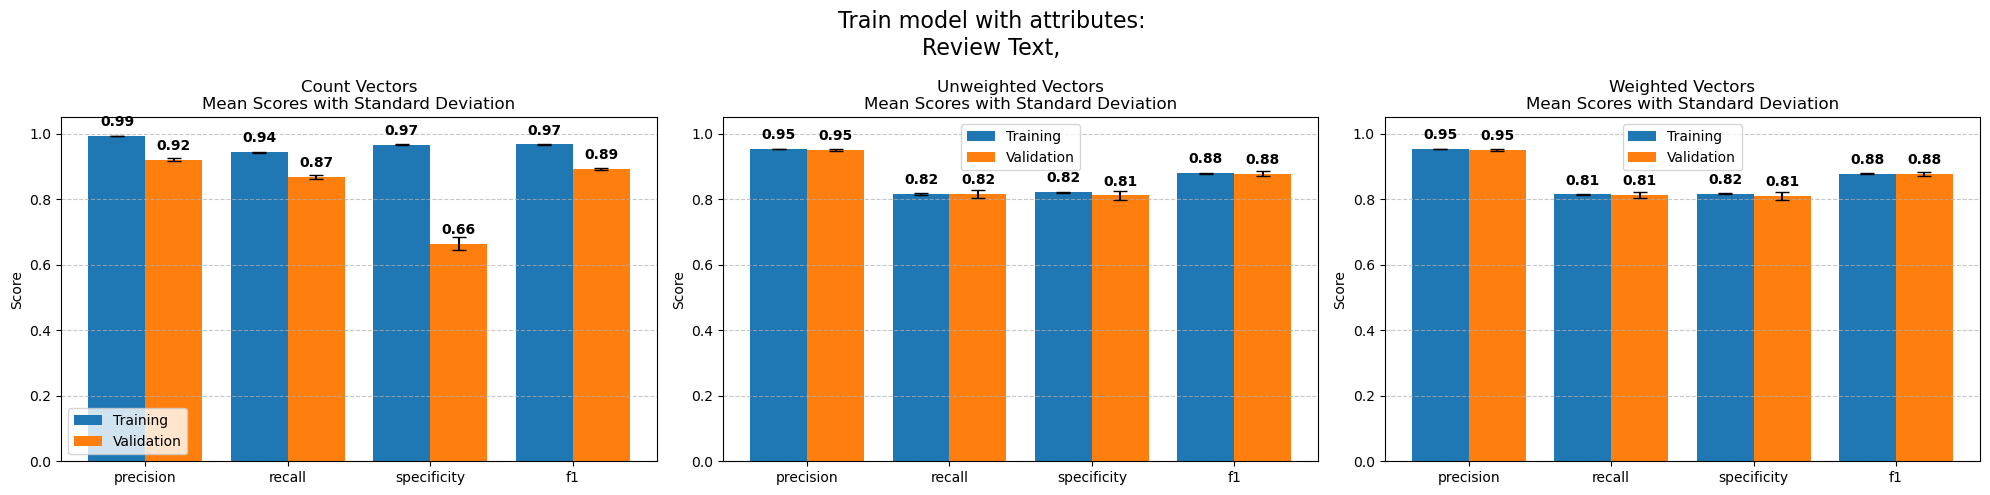

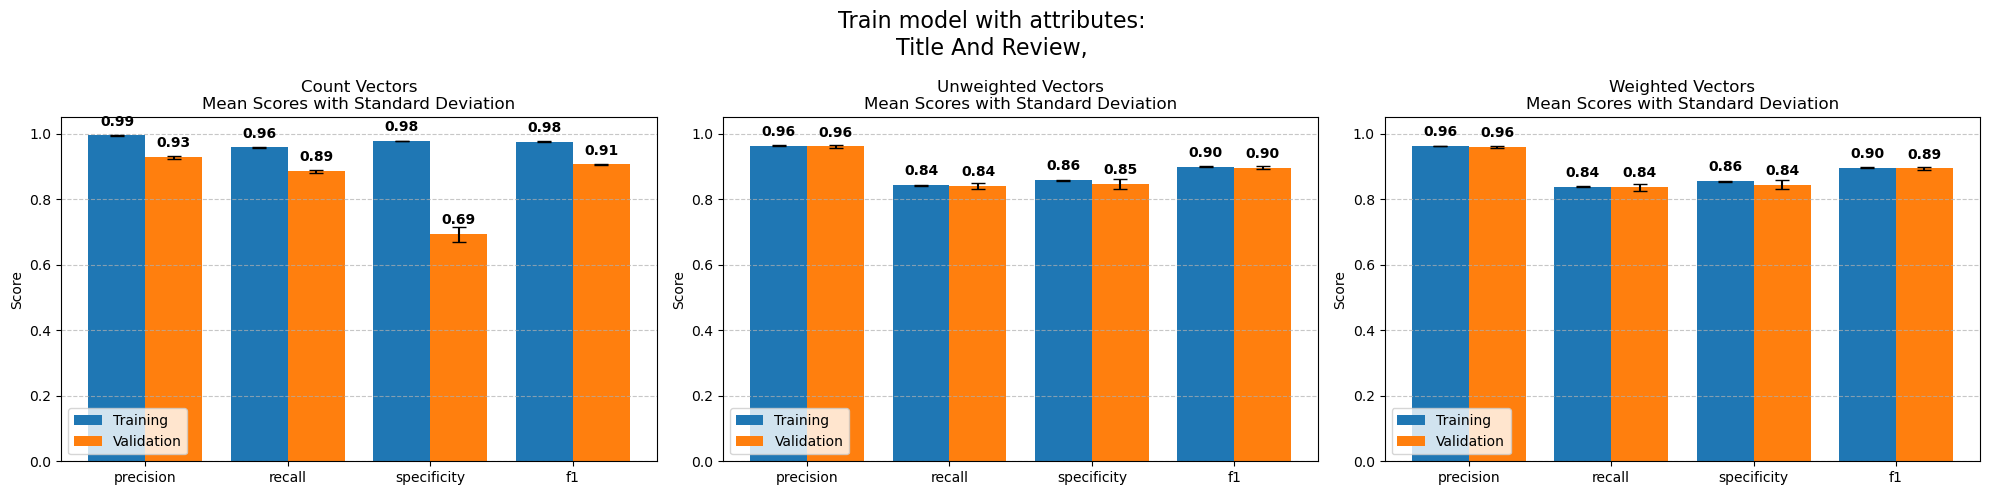

In [23]:
# train SVM with processed_23

# ---- Train with "Title" ----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title', vocab_title, fasttext_title_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

test_model(svm_clf, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Title')

# ---- Train with "Review Text" ----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

test_model(svm_clf, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Review Text')

# ---- Train with "Title And Review" ----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

test_model(svm_clf, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Title And Review')

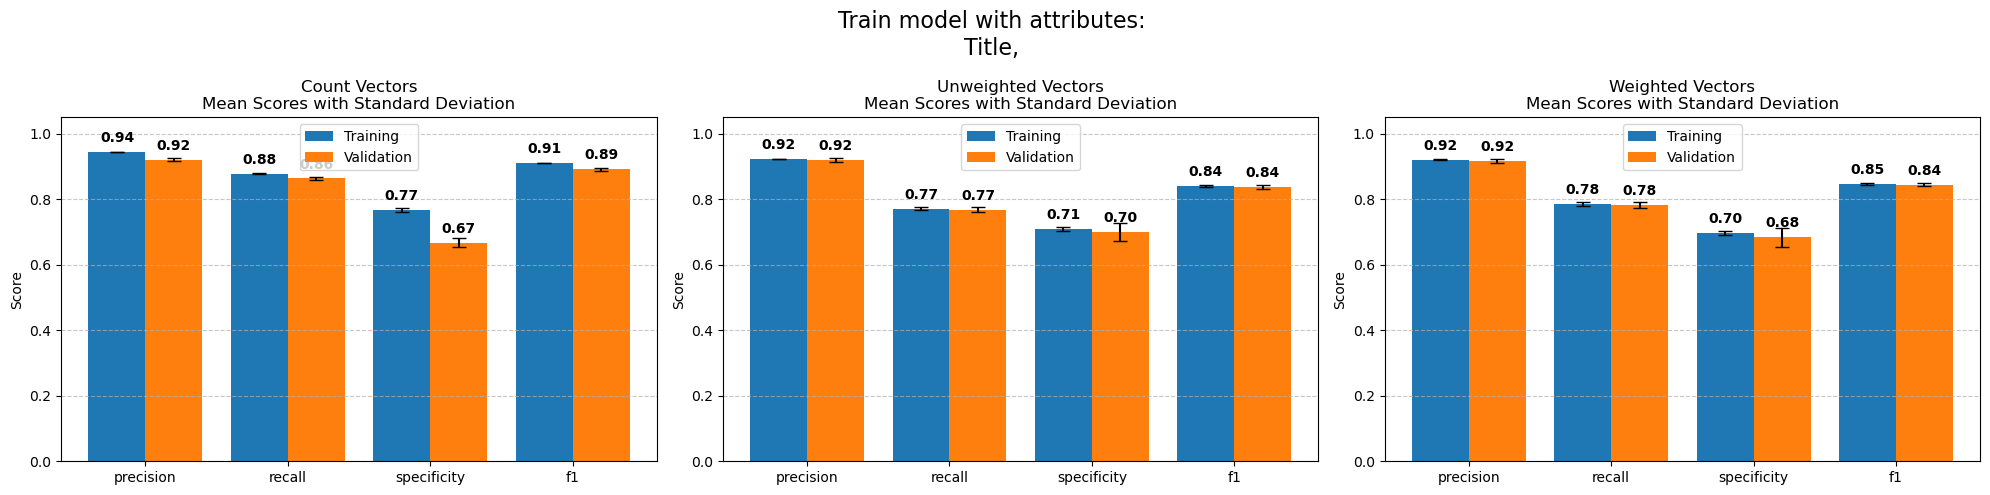

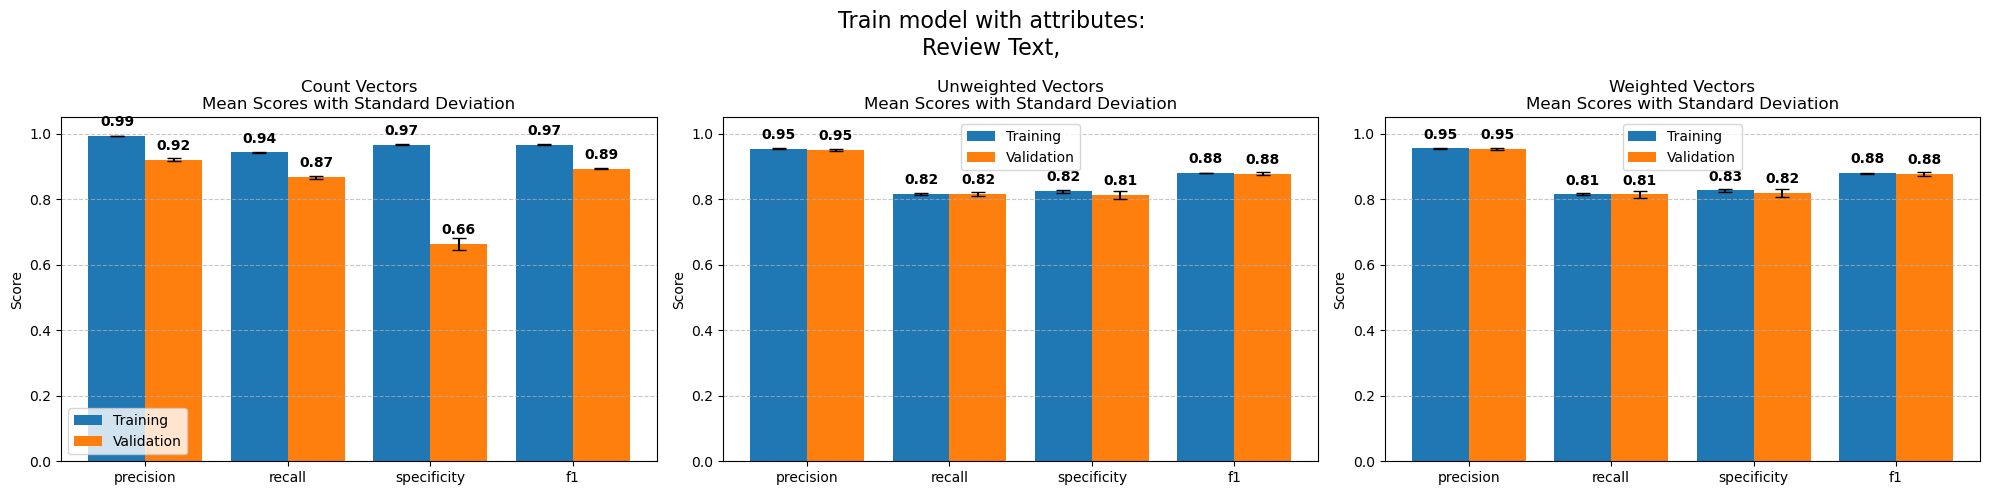

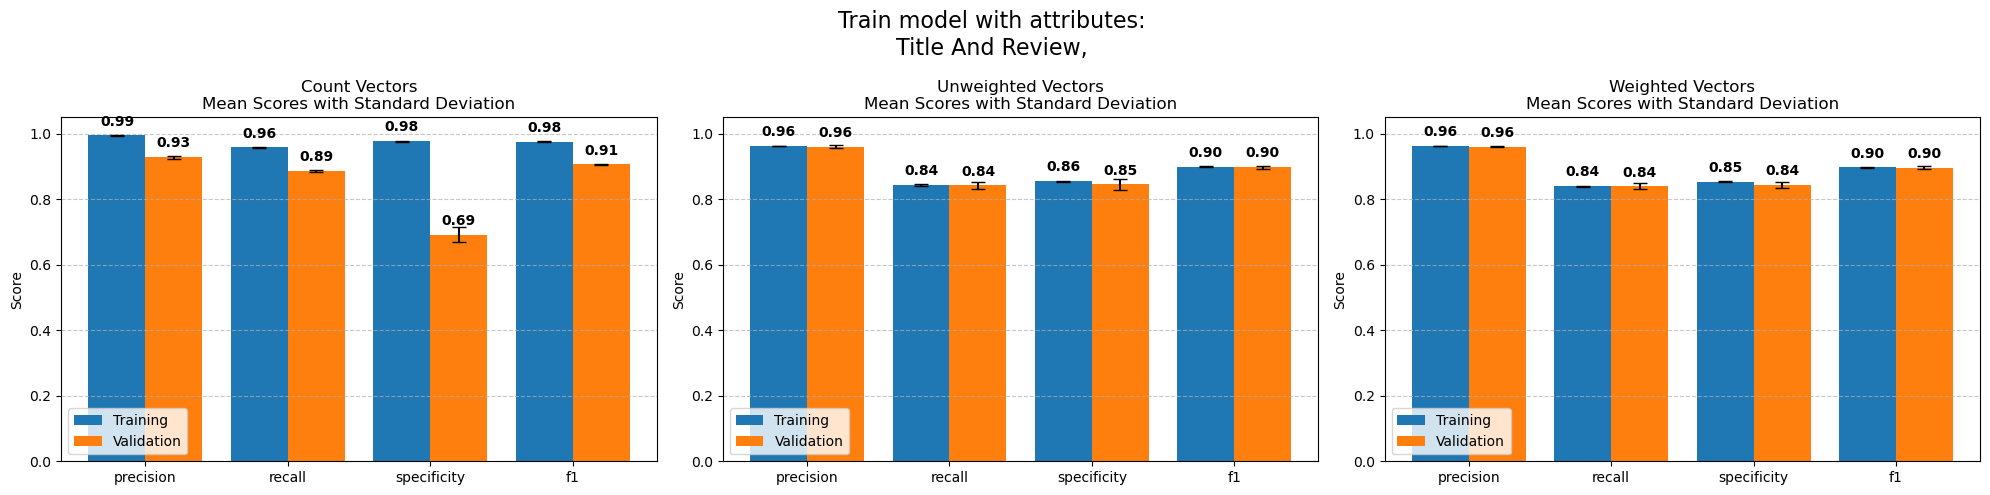

In [24]:
# train SVM with processed_234

# ---- Train with "Title" ----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title', vocab_title_234, fasttext_234_title_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

test_model(svm_clf, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Title')

# ---- Train with "Review Text" ----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Review Text', vocab_text_234, fasttext_234_text_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

test_model(svm_clf, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Review Text')

# ---- Train with "Title And Review" ----
# Count vectors (sparse), 2 Embeddings vectors (dense)
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title And Review', vocab_both, fasttext_234_both_model)
scaler_uw = StandardScaler()
unweighted_vectors_scaled = scaler_uw.fit_transform(unweighted_vectors) # Scale dense vectors
scaler_w = StandardScaler()
weighted_vectors_scaled = scaler_w.fit_transform(weighted_vectors) # Scale dense vectors

test_model(svm_clf, df, count_vectors, unweighted_vectors_scaled, weighted_vectors_scaled, 'Title And Review')

#### 3.2.3. XGBoost Classification

In [25]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)

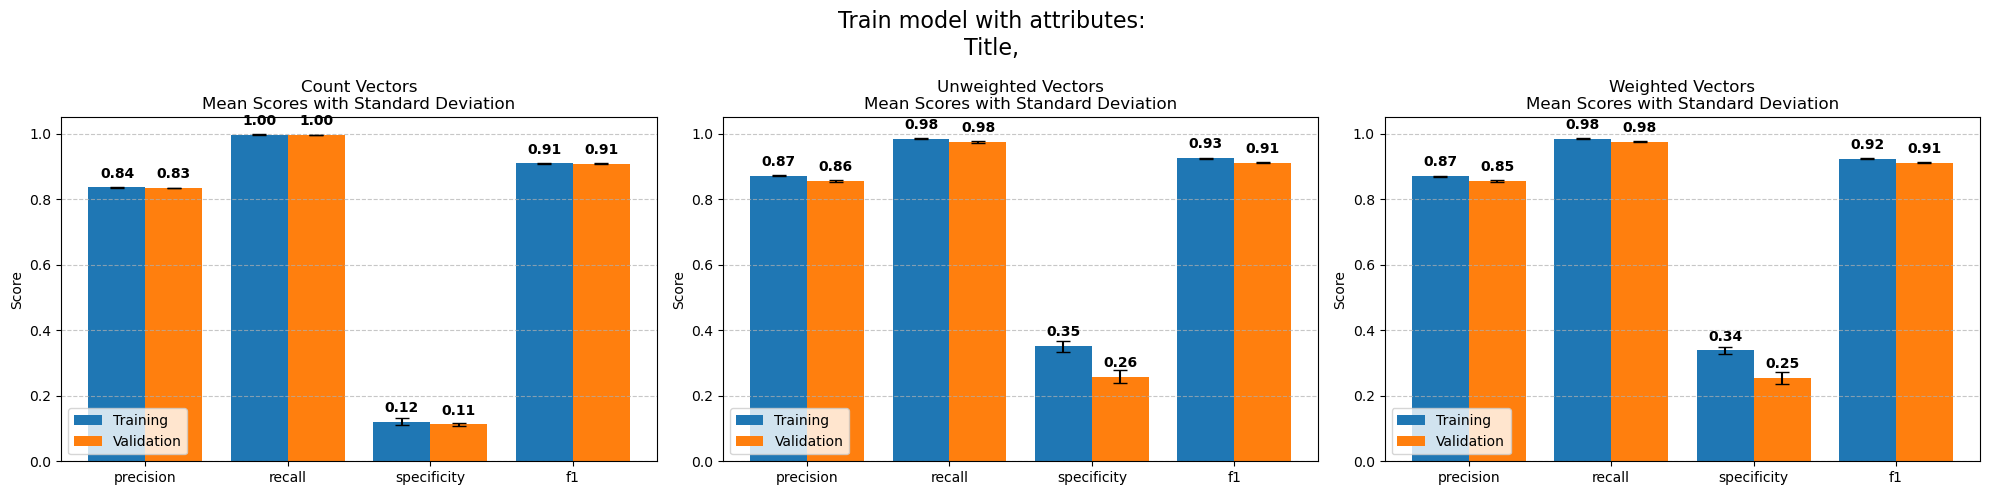

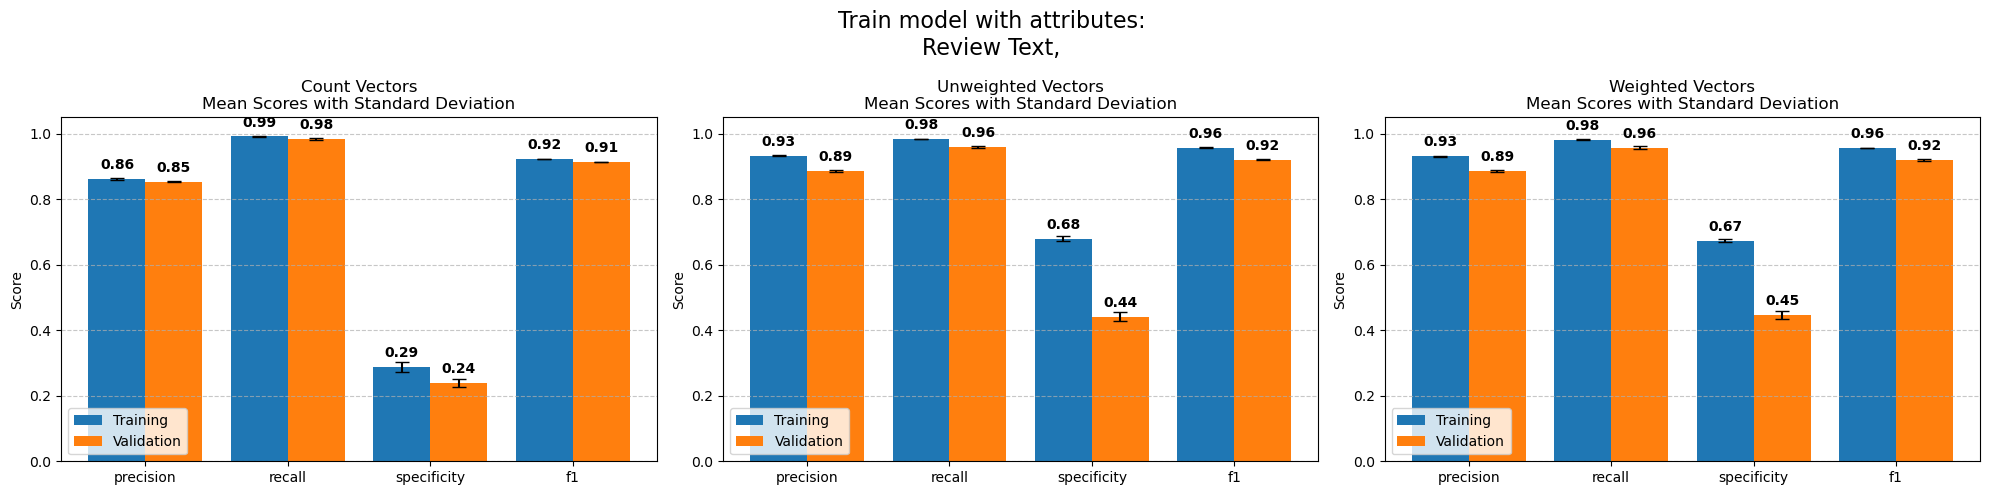

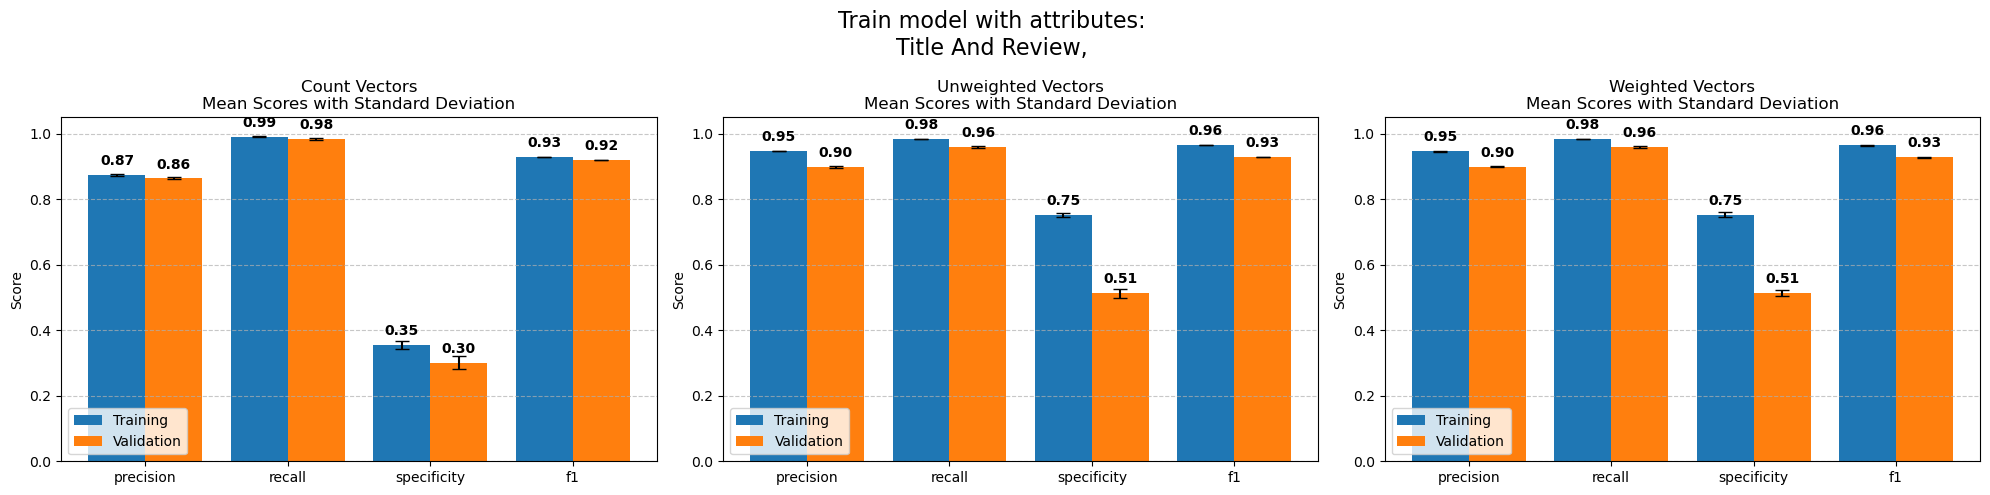

In [26]:
# train XGBoost model for processed_23

# train with 'Title'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title', vocab_title, fasttext_title_model)
test_model(xgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# train with 'Review Text'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)
test_model(xgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# train with 'Title And Review'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(xgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

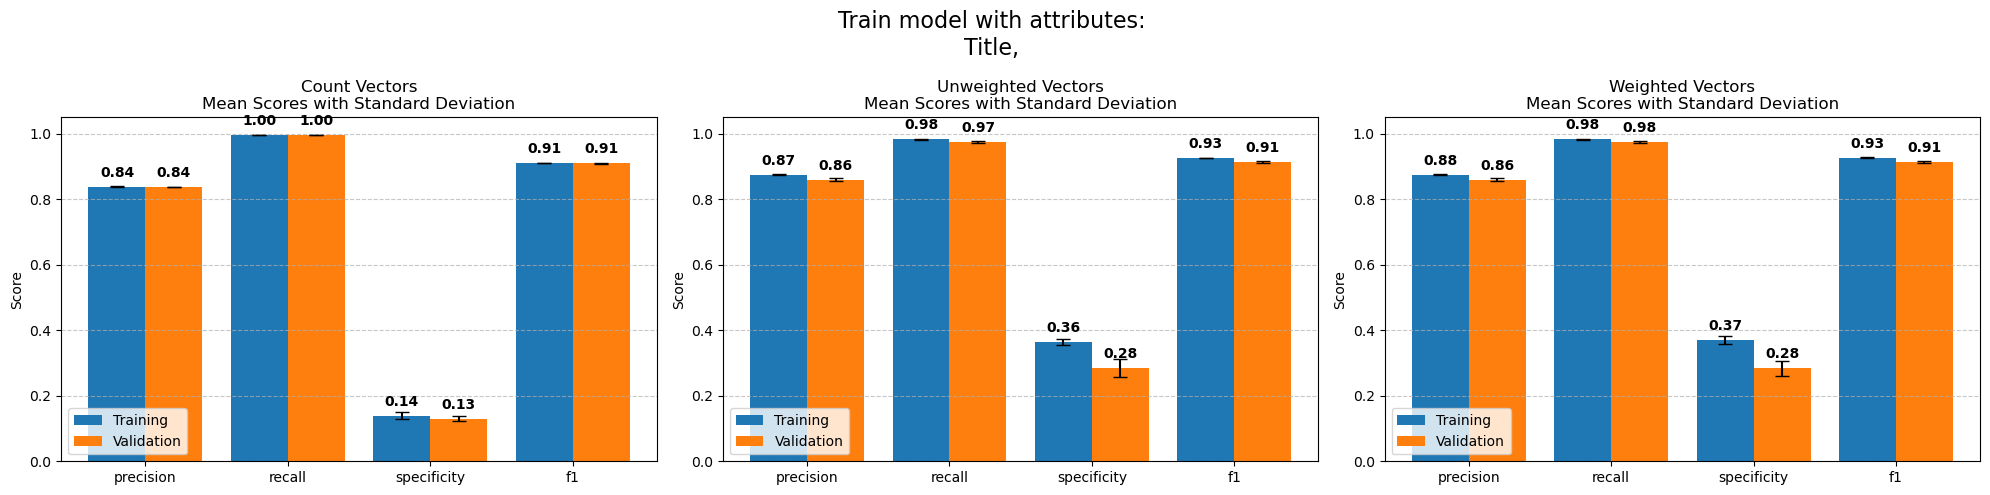

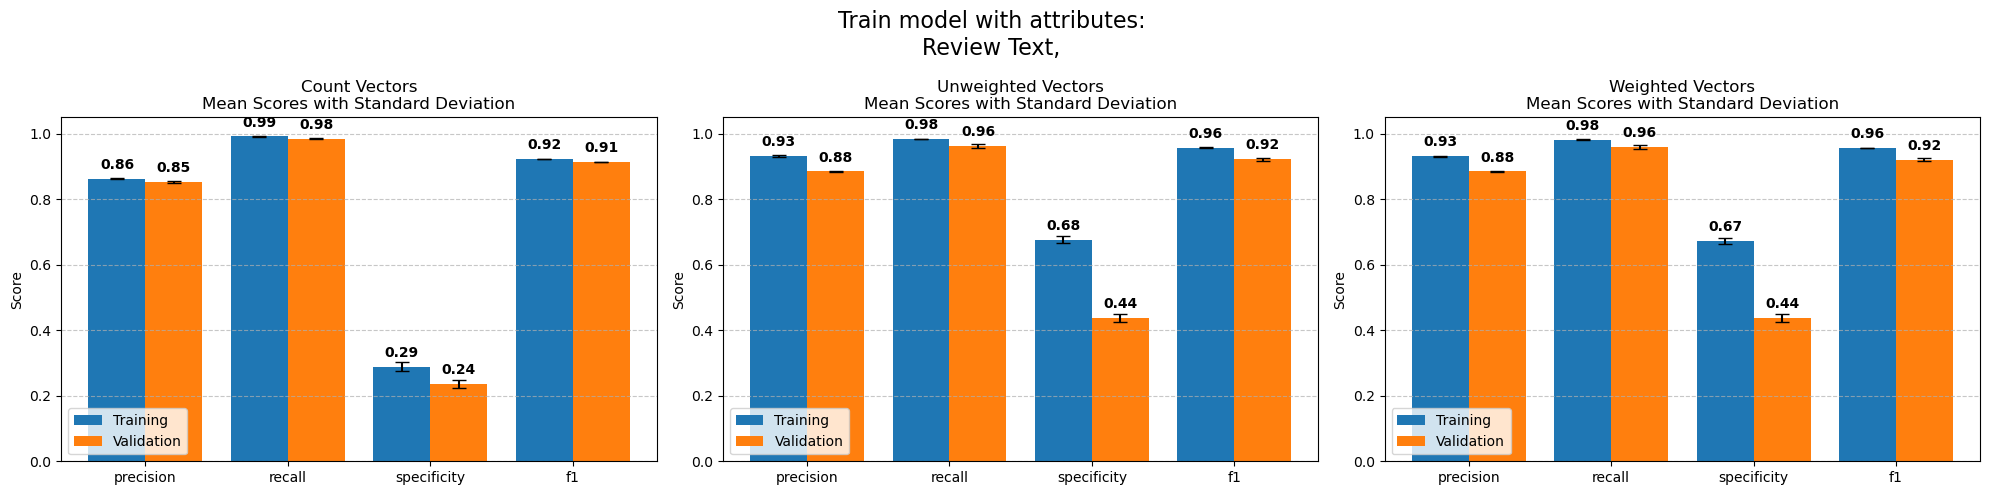

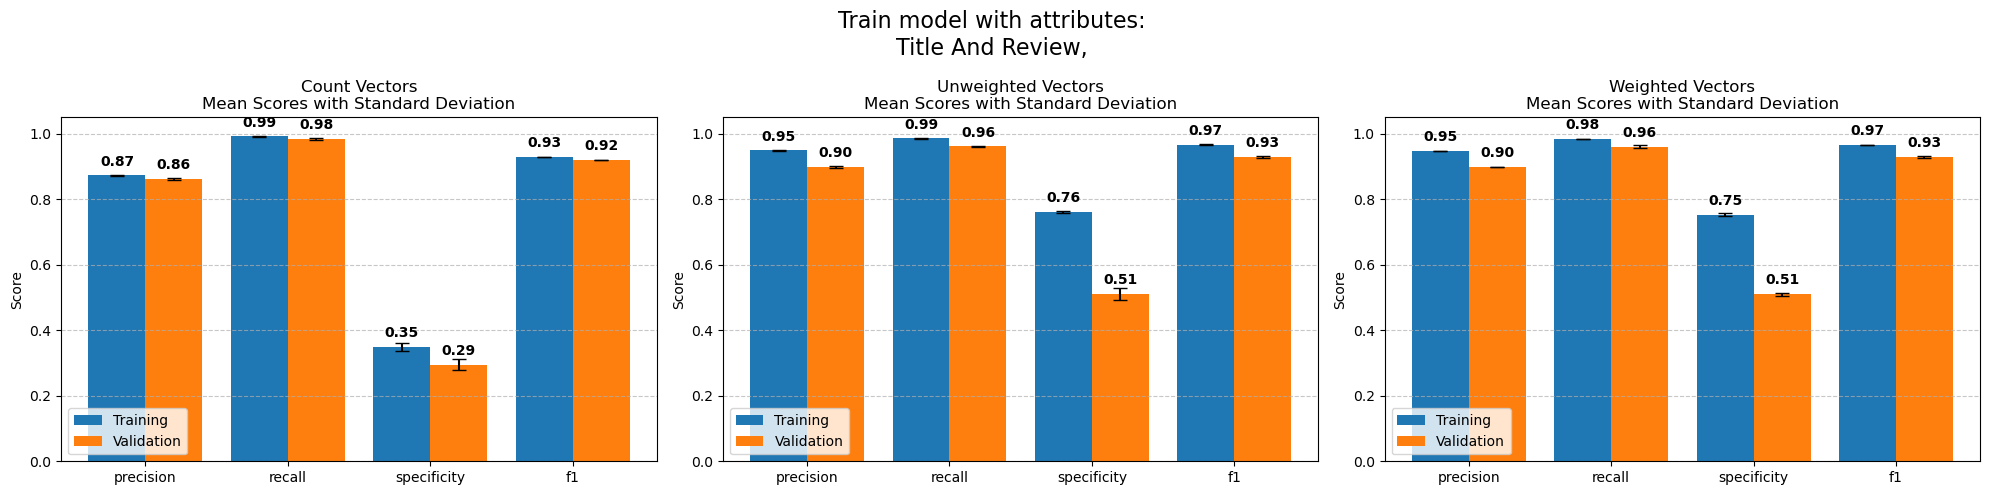

In [27]:
# train XGBoost model for processed_234

# train with 'Title'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title', vocab_title_234, fasttext_234_title_model)
test_model(xgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# train with 'Review Text'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Review Text', vocab_text_234, fasttext_234_text_model)
test_model(xgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# train with 'Title And Review'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title And Review', vocab_both_234, fasttext_234_both_model)
test_model(xgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

3.2.4 CatBoost

In [28]:
cat_clf = CatBoostClassifier(iterations=100,
  learning_rate=0.05,
  depth=6,
  loss_function='Logloss',
  random_seed=42,
  verbose=0,
  auto_class_weights='Balanced',
  l2_leaf_reg=3.0,
  bootstrap_type='Bayesian'
)

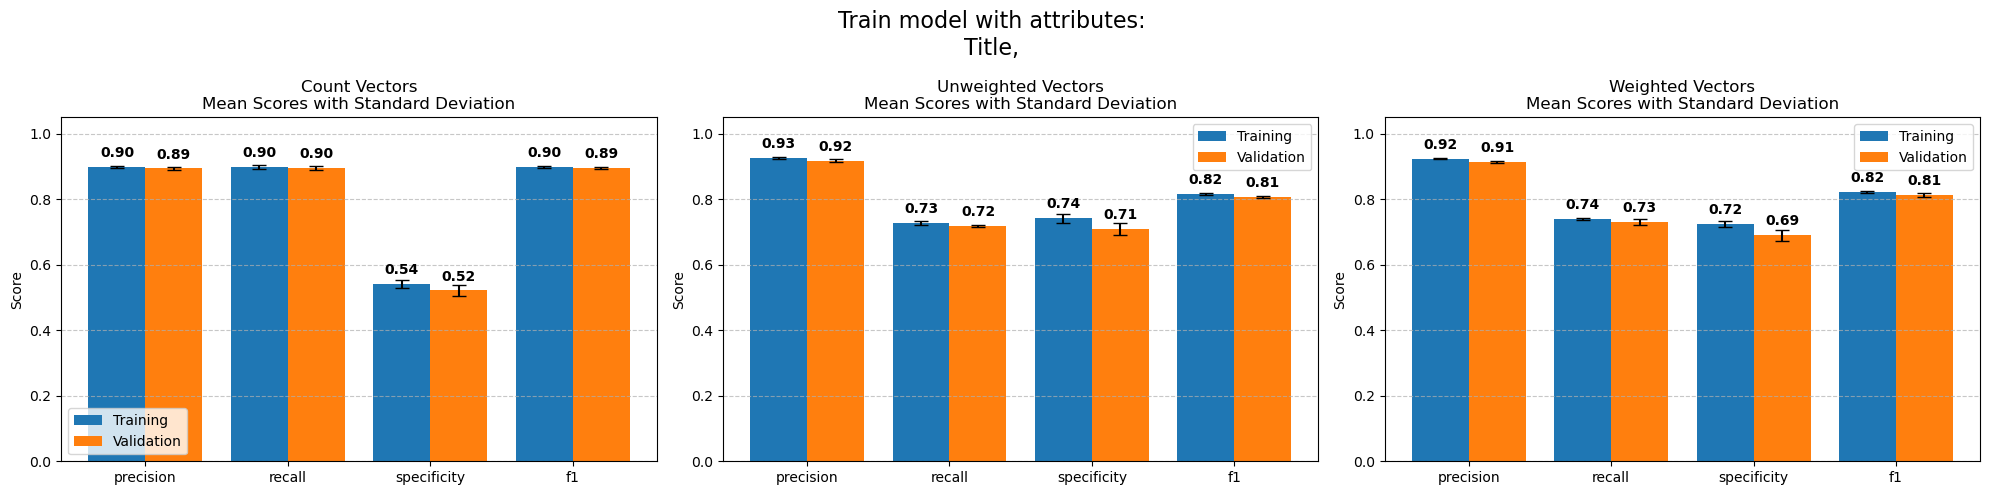

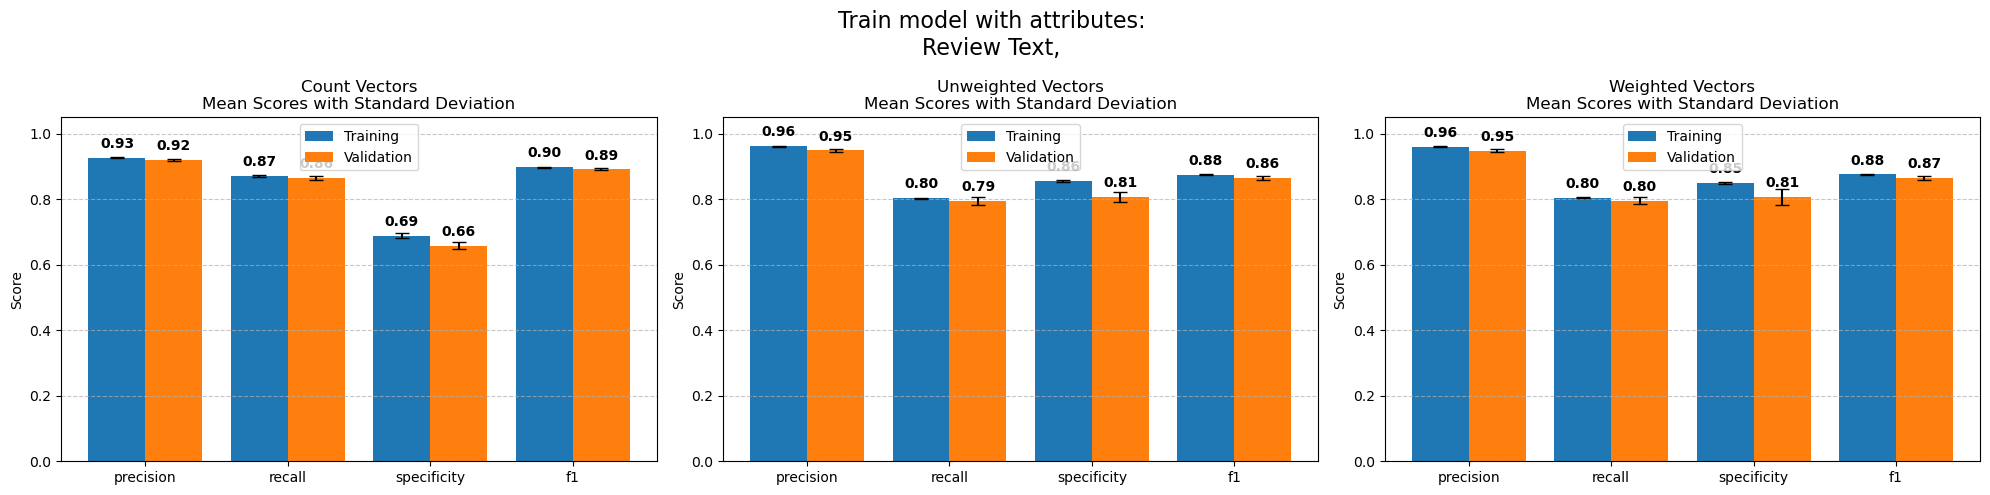

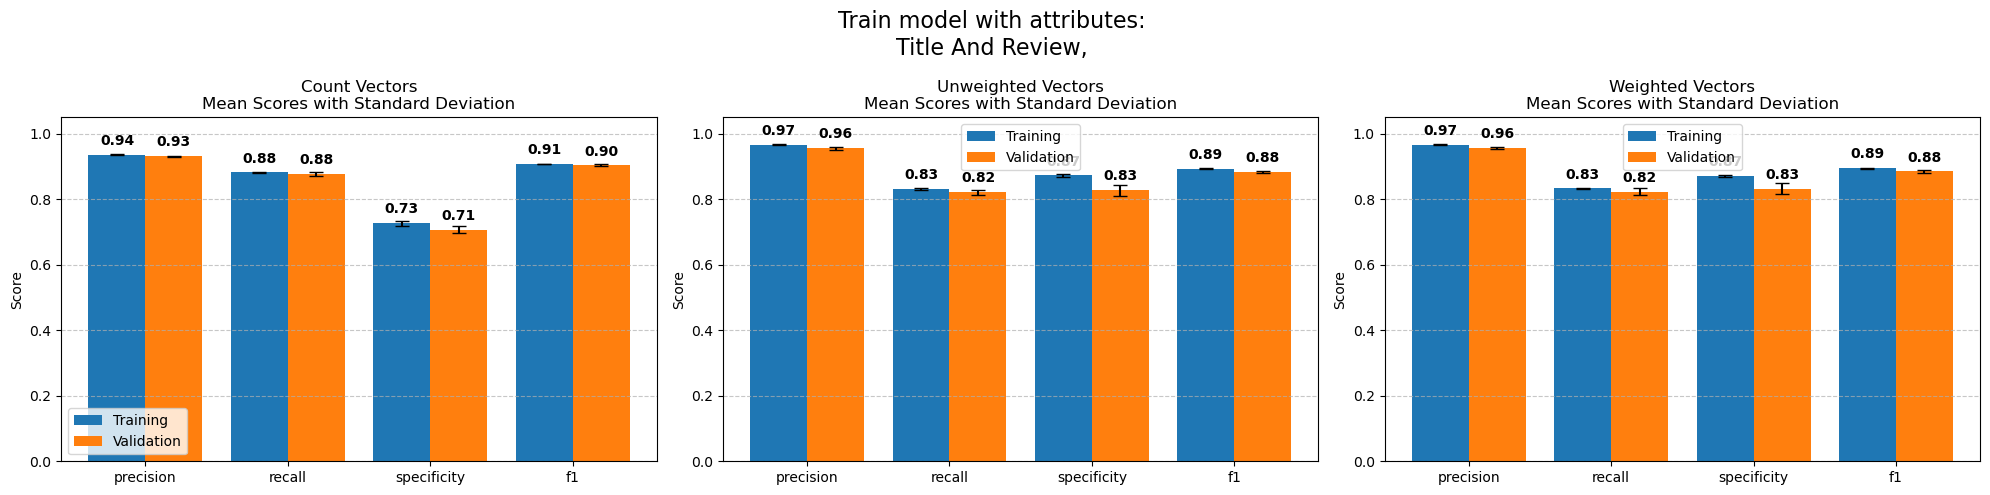

In [29]:
# train CatBoost model for processed_23

# train with 'Title'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title', vocab_title, fasttext_title_model)
test_model(cat_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# train with 'Review Text'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)
test_model(cat_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# train with 'Title And Review'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(cat_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

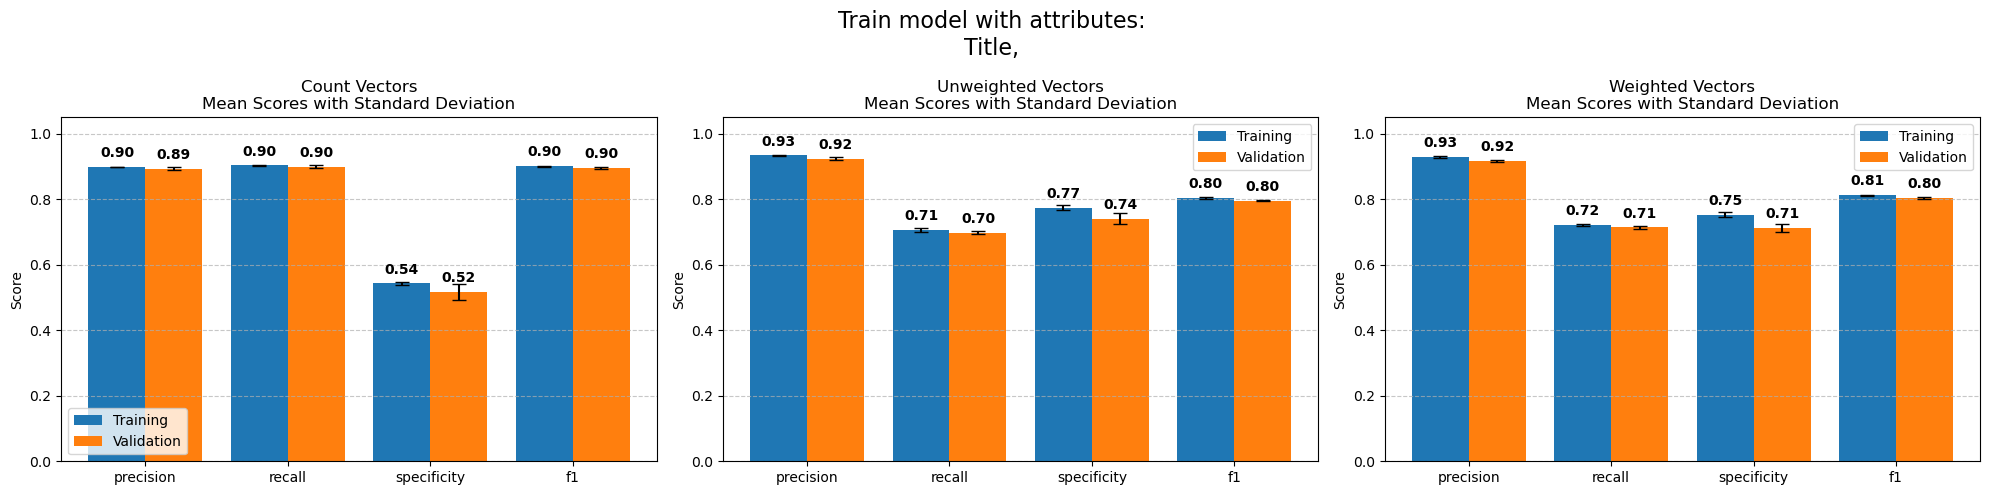

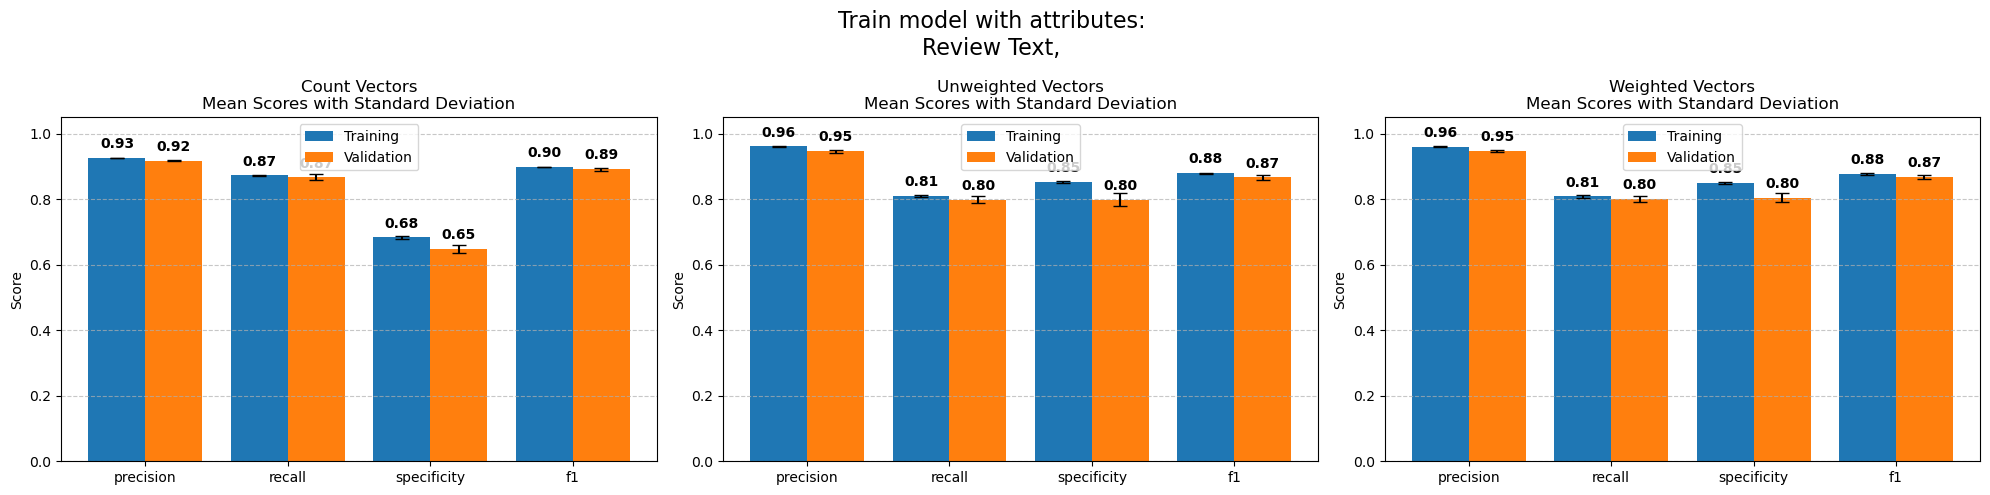

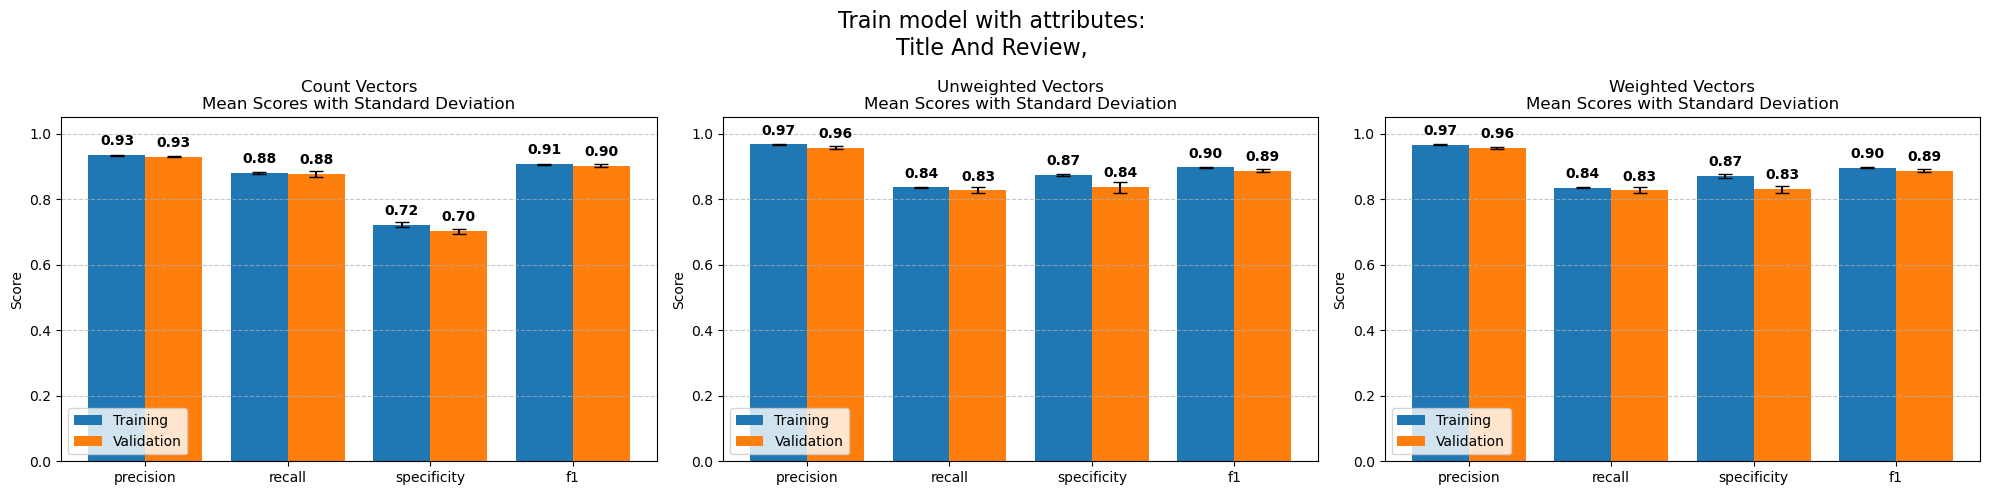

In [30]:
# train CatBoost model for processed_234

# train with 'Title'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title', vocab_title_234, fasttext_234_title_model)
test_model(cat_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# train with 'Review Text'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Review Text', vocab_text_234, fasttext_234_text_model)
test_model(cat_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# train with 'Title And Review'
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title And Review', vocab_both_234, fasttext_234_both_model)
test_model(cat_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

#### 3.2.5 LGBoost

In [31]:
# Define LightGBM model with parameters to handle class imbalance
lgb_clf = lgb.LGBMClassifier(
    boosting_type='gbdt',           # Gradient Boosting Decision Tree
    n_estimators=100,               # Number of trees
    learning_rate=0.05,             # Learning rate
    num_leaves=31,                  # Max number of leaves in one tree
    max_depth=-1,                   # No limit on depth
    class_weight='balanced',        # Automatically adjust weights inversely proportional to class frequencies
    min_child_samples=20,           # Minimum samples required in a leaf
    subsample=0.8,                  # Subset of training data to use for each tree
    colsample_bytree=0.8,           # Subset of features to use for each tree
    reg_alpha=0.1,                  # L1 regularization
    reg_lambda=1.0,                 # L2 regularization
    random_state=42,                # For reproducibility
    verbose = 0,                    # No logs on console
)

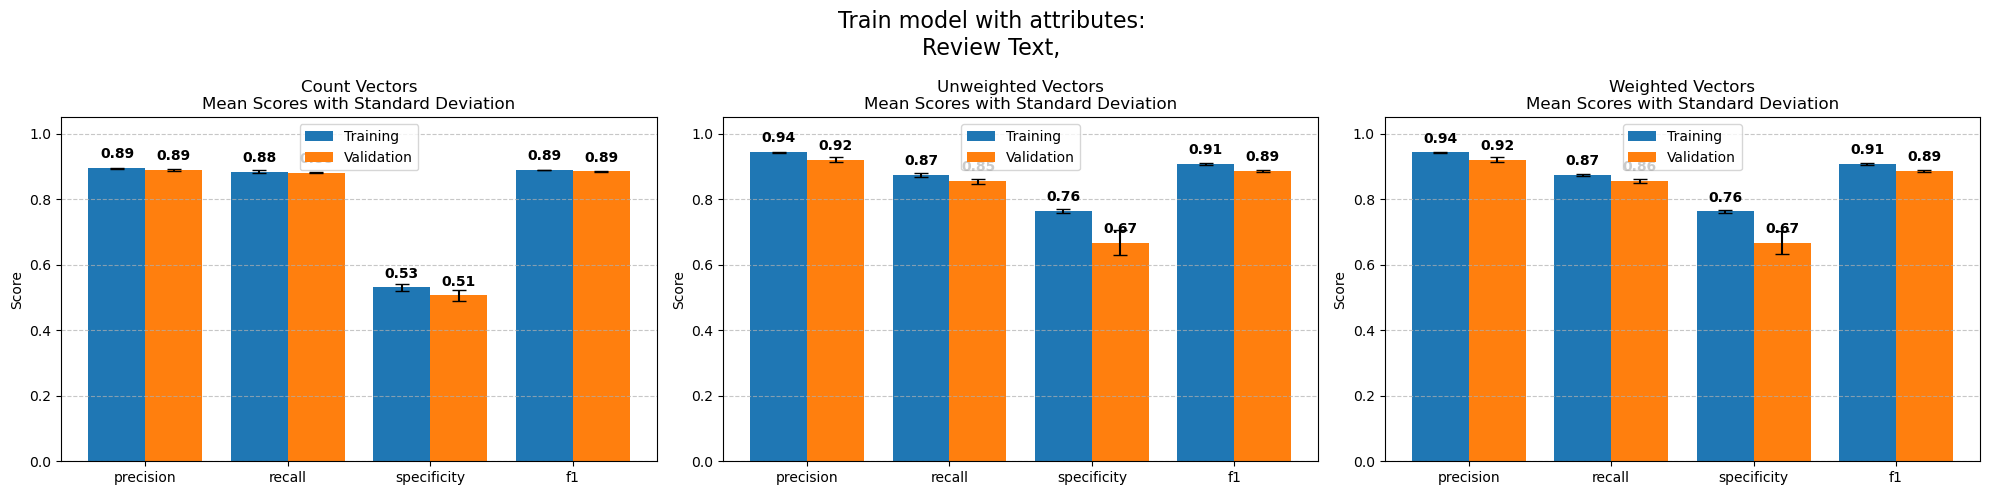

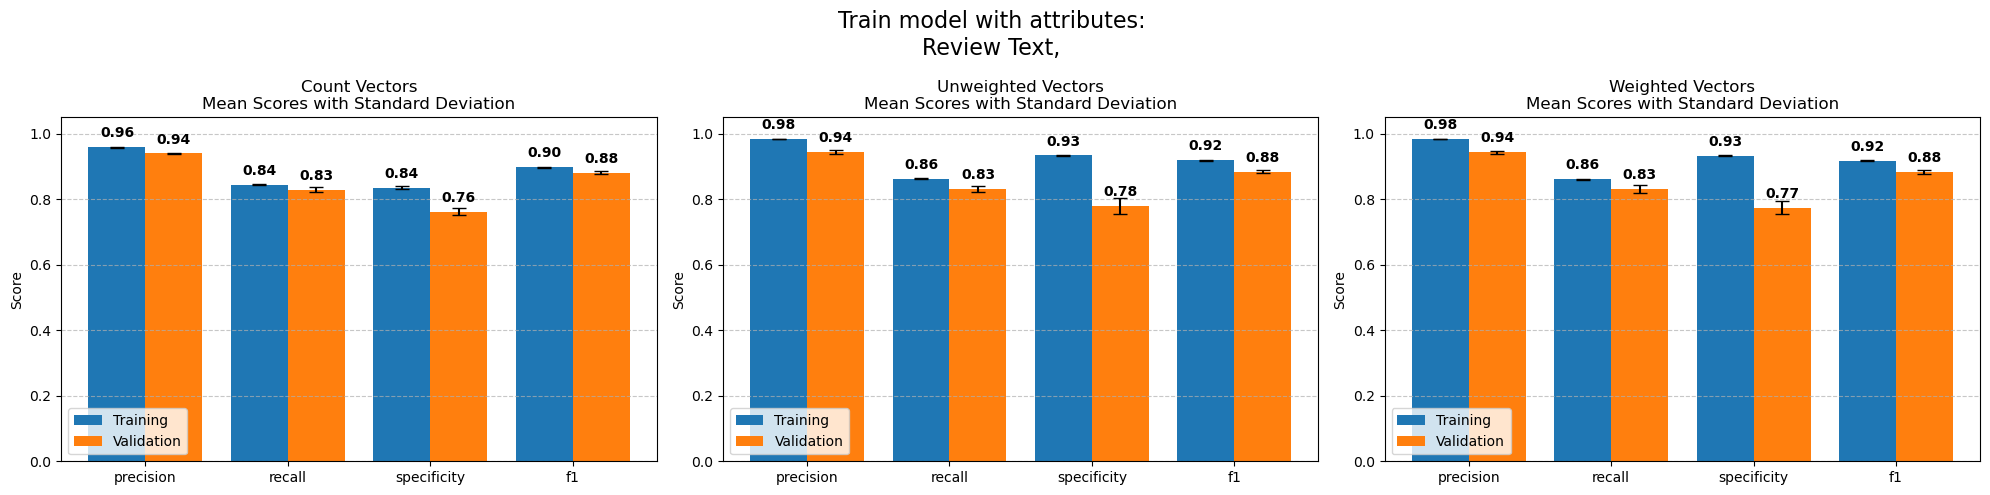

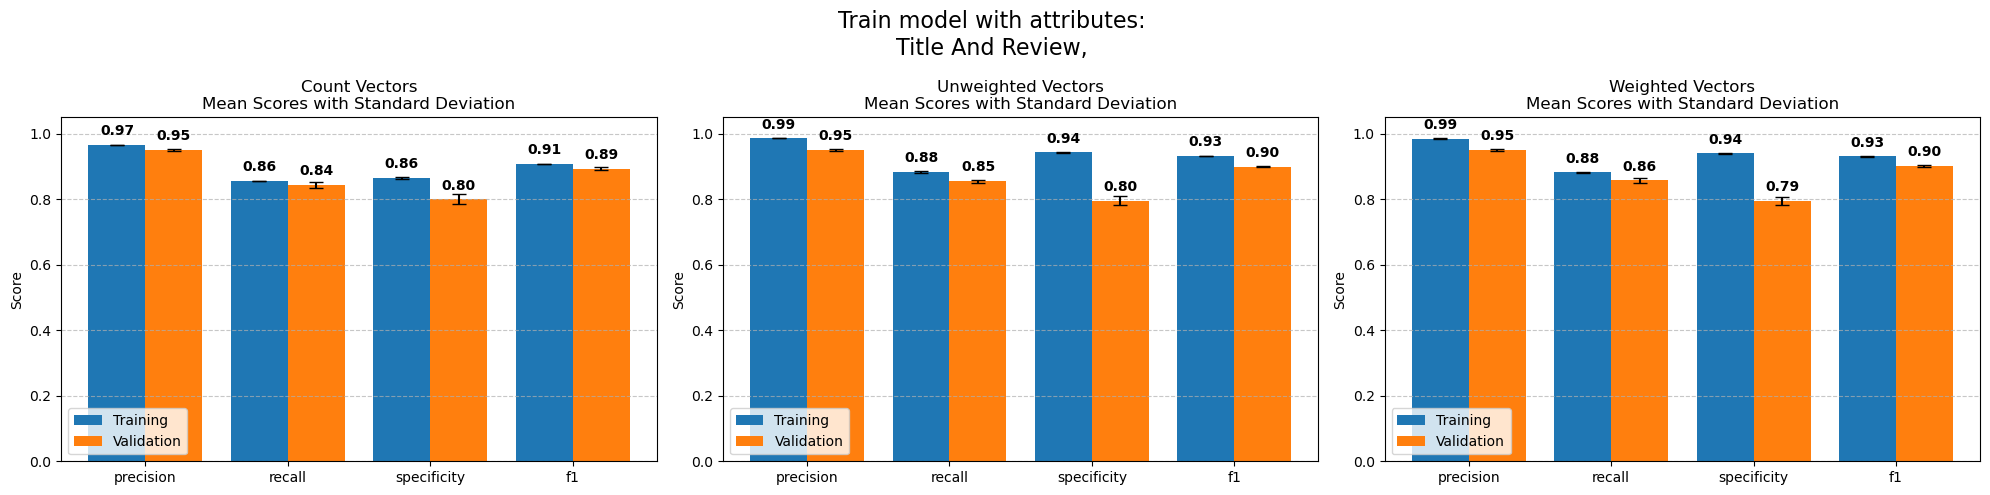

In [32]:
#Train LightBoost model for processed_23

# Train with Title
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title', vocab_title, fasttext_text_model)
test_model(lgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# Train with Review Text
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)
test_model(lgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# Train with Title And Review
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(lgb_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

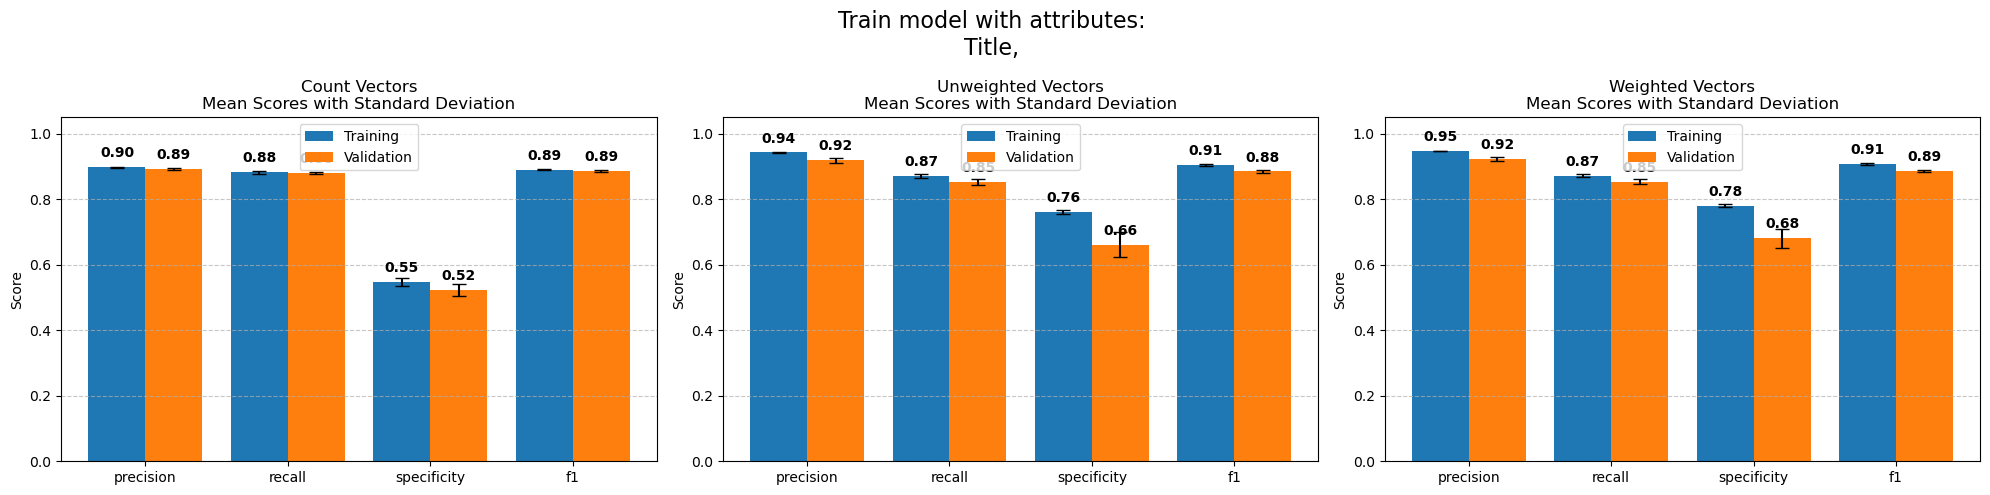

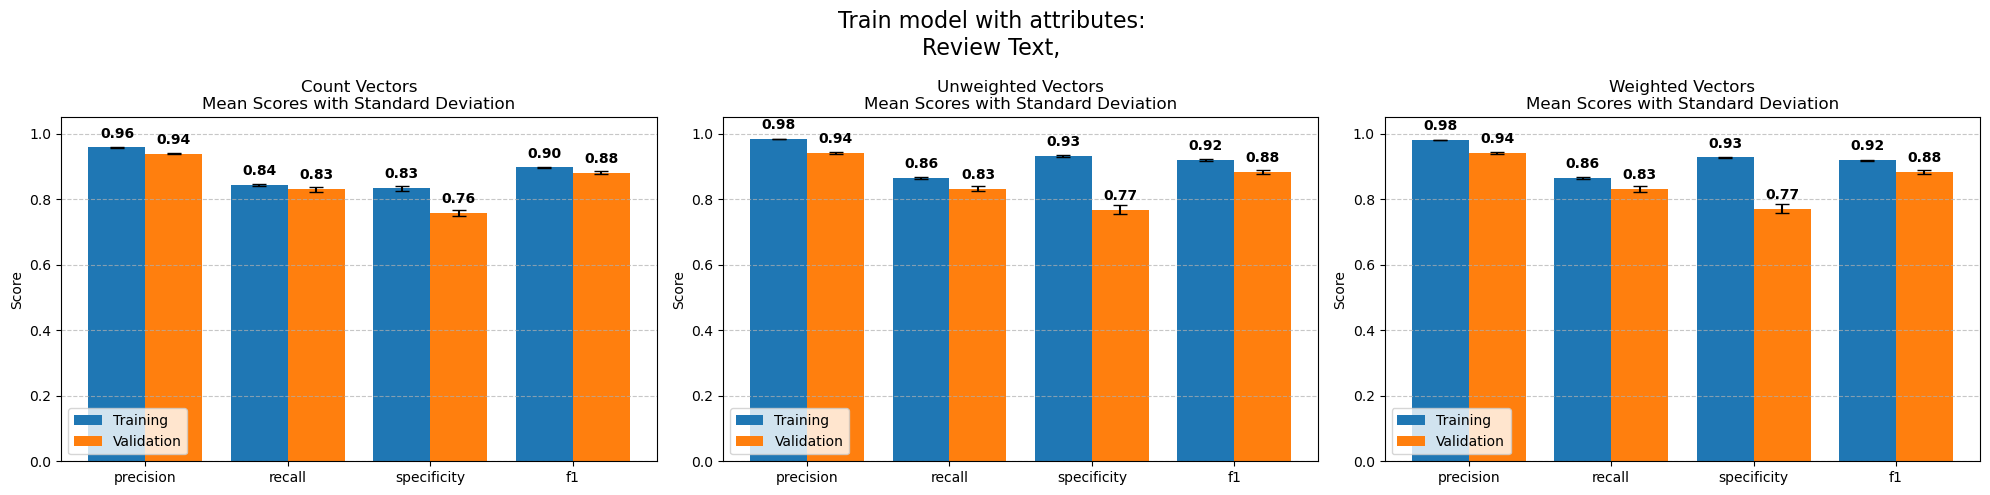

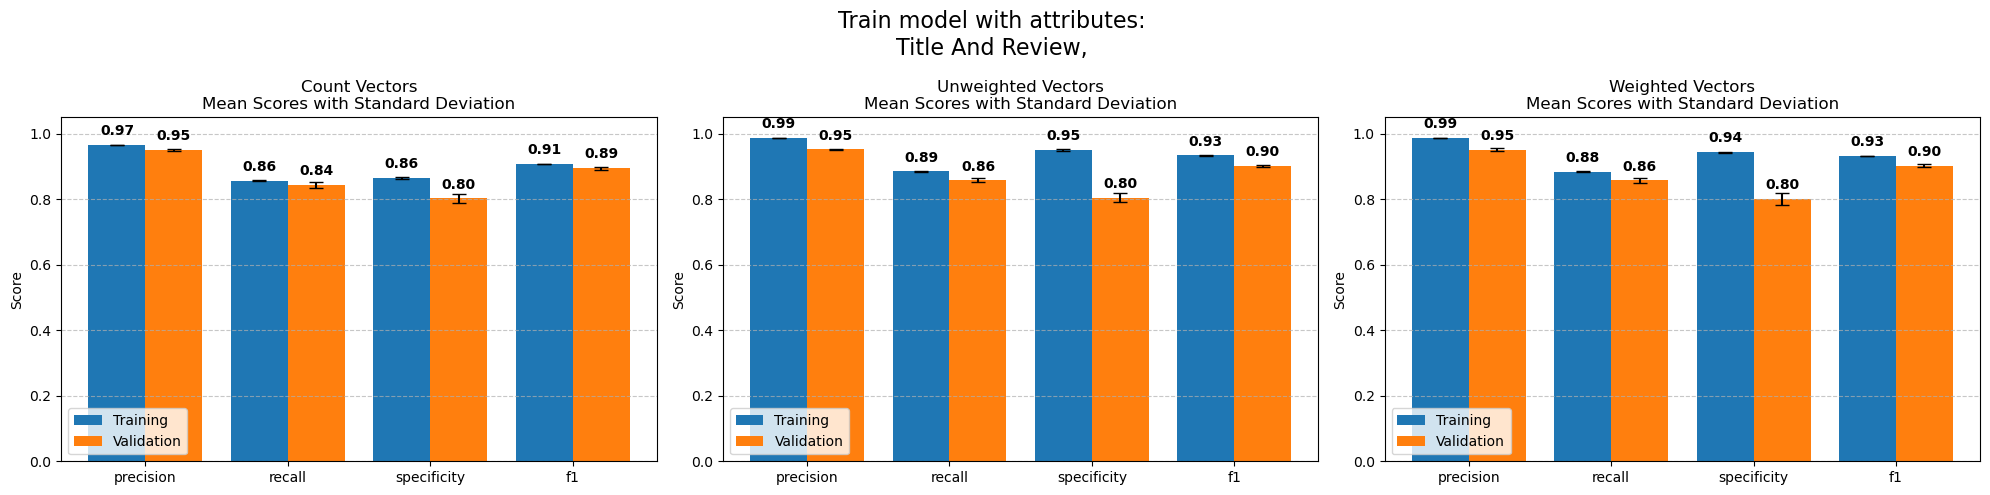

In [33]:
#Train LightBoost model for processed_234

# Train with Title
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title', vocab_title_234, fasttext_234_text_model)
test_model(lgb_clf, df_234, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# Train with Review Text
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Review Text', vocab_text_234, fasttext_234_text_model)
test_model(lgb_clf, df_234, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# Train with Title And Review
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title And Review', vocab_both_234, fasttext_234_both_model)
test_model(lgb_clf, df_234, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

#### 3.2.6. Adaboost

In [34]:
# Create AdaBoost classifier
base_estimator = DecisionTreeClassifier(
    max_depth=2,                # Shallow trees to avoid overfitting
    min_samples_leaf=5,         # Require minimum samples in leaf nodes
    class_weight='balanced'     # Critical for handling imbalance
)

ada_clf = AdaBoostClassifier(
    estimator=base_estimator,   # Use balanced estimator (or base_estimator in older versions)
    n_estimators=150,
    learning_rate=0.05,
    algorithm='SAMME',
    random_state=42
)



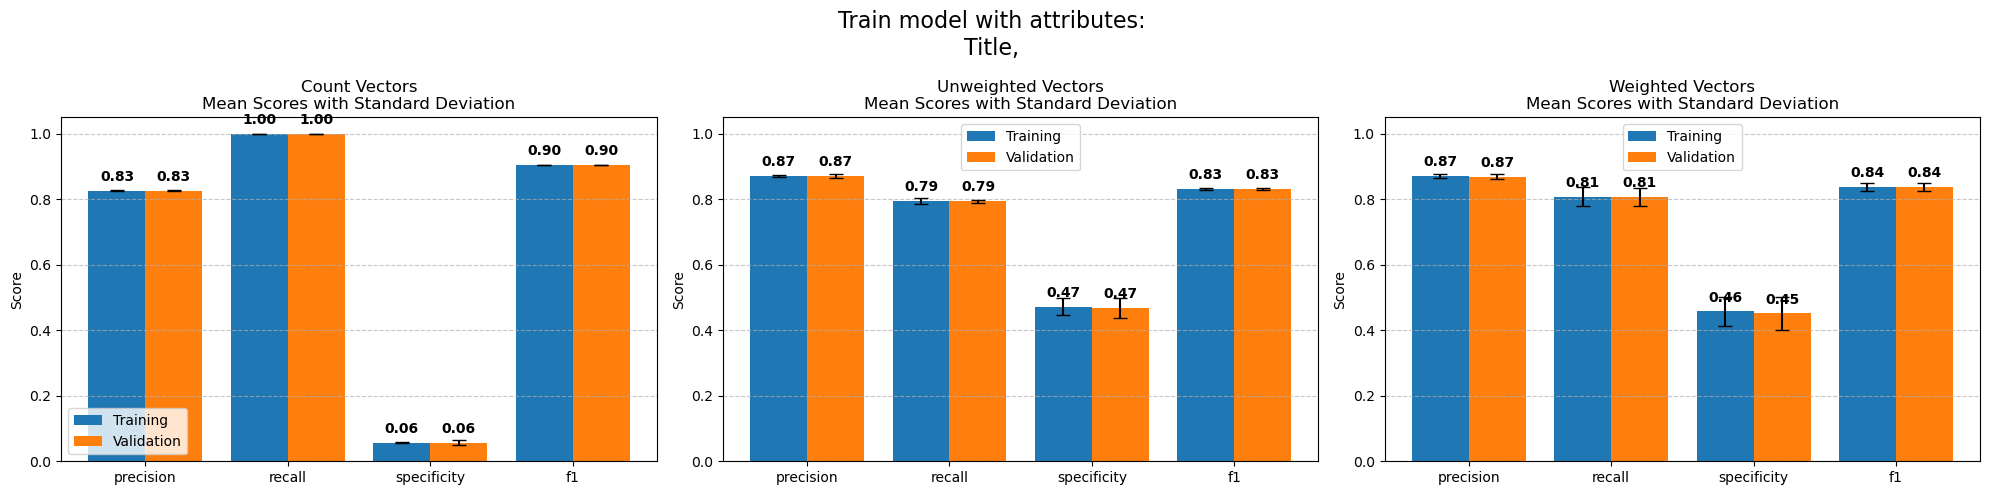

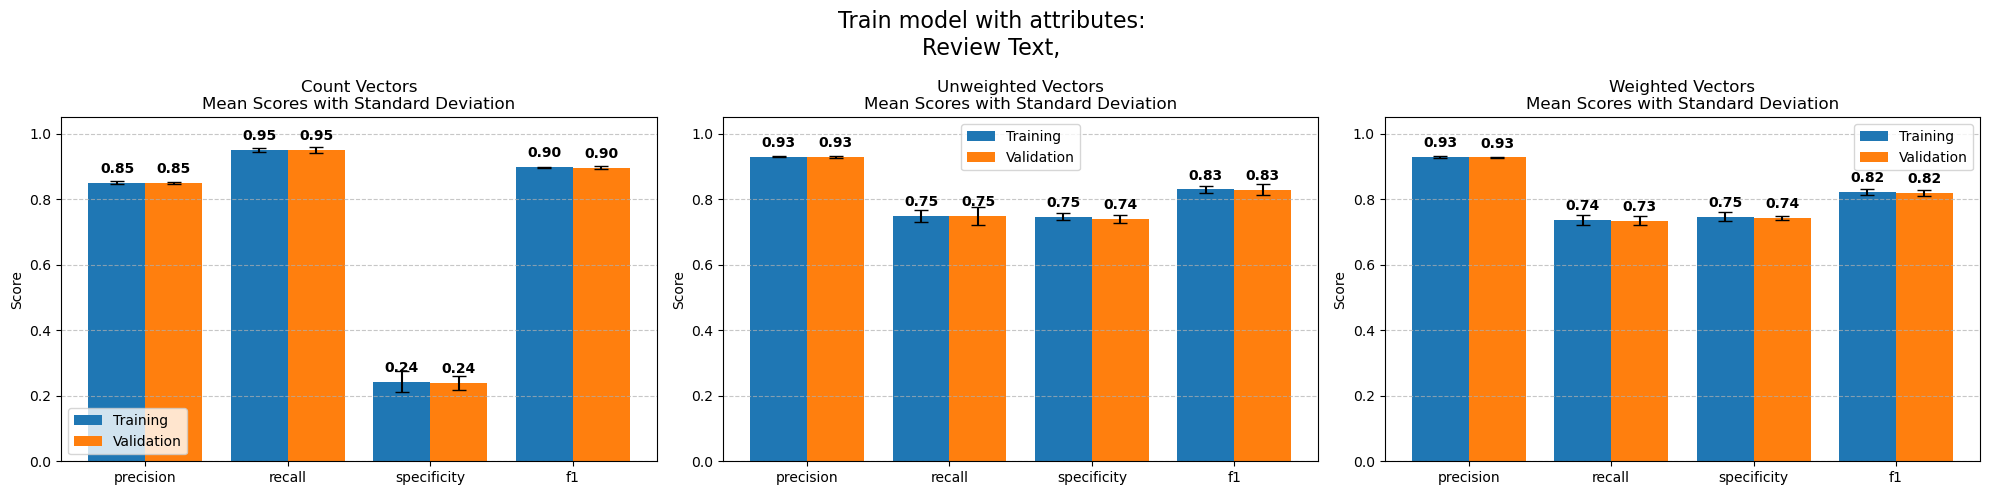

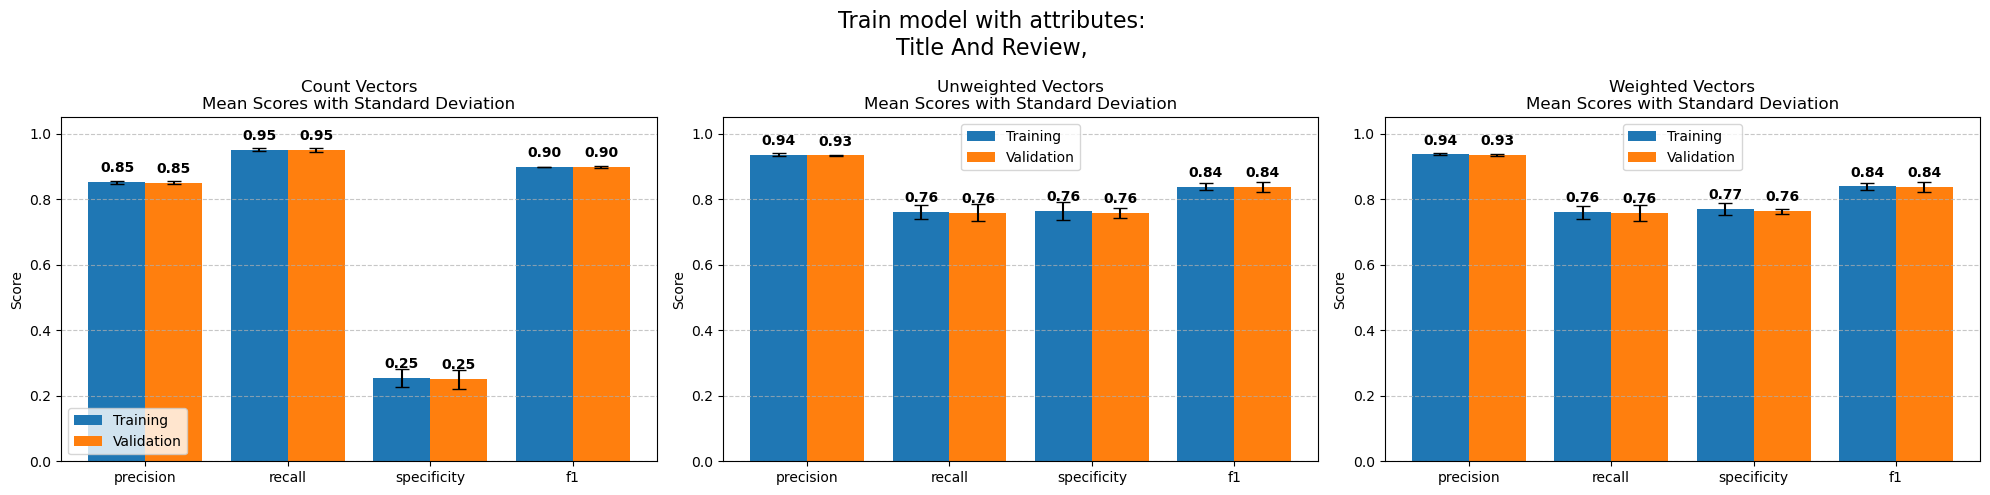

In [35]:
# Train AdaBoost with processed vocab_23
# Train with Title
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title', vocab_title, fasttext_title_model)
test_model(ada_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# Train with Review Text
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Review Text', vocab_text, fasttext_text_model)
test_model(ada_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# Train with Title And Review
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df, 'Title And Review', vocab_both, fasttext_both_model)
test_model(ada_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')

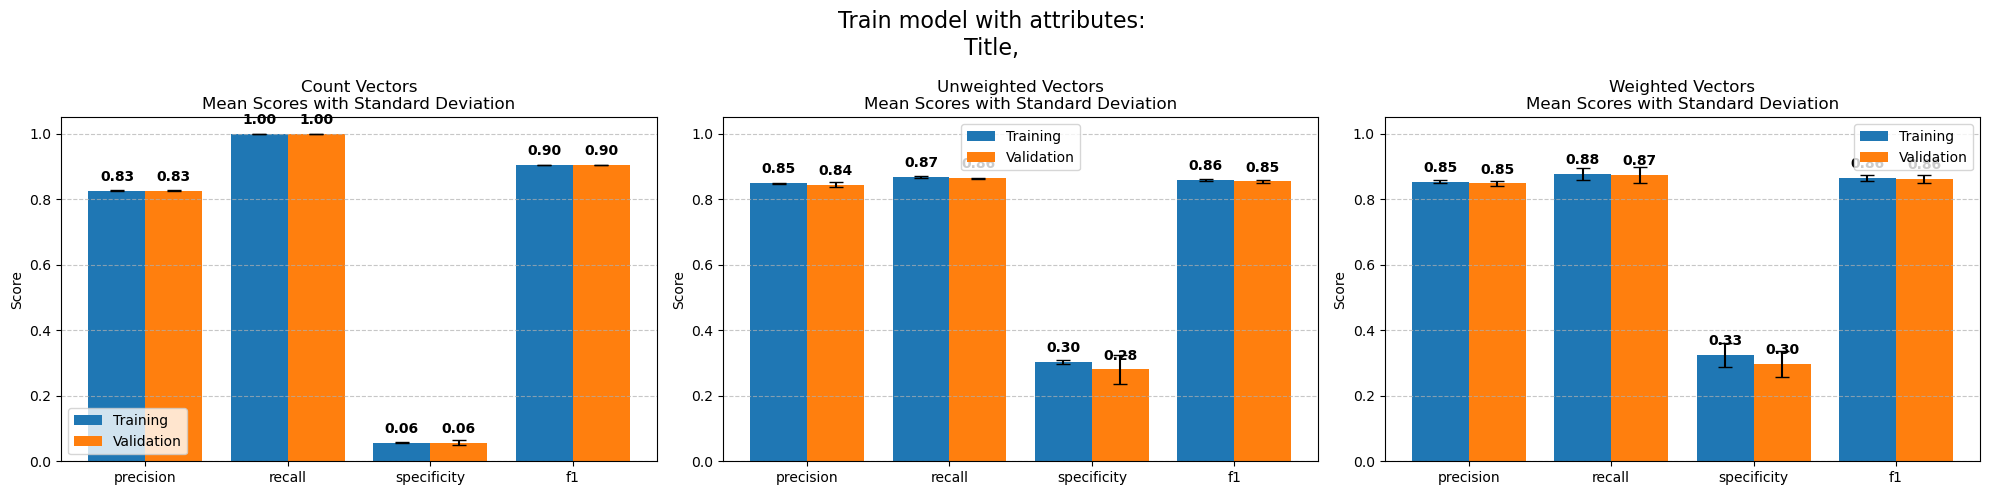

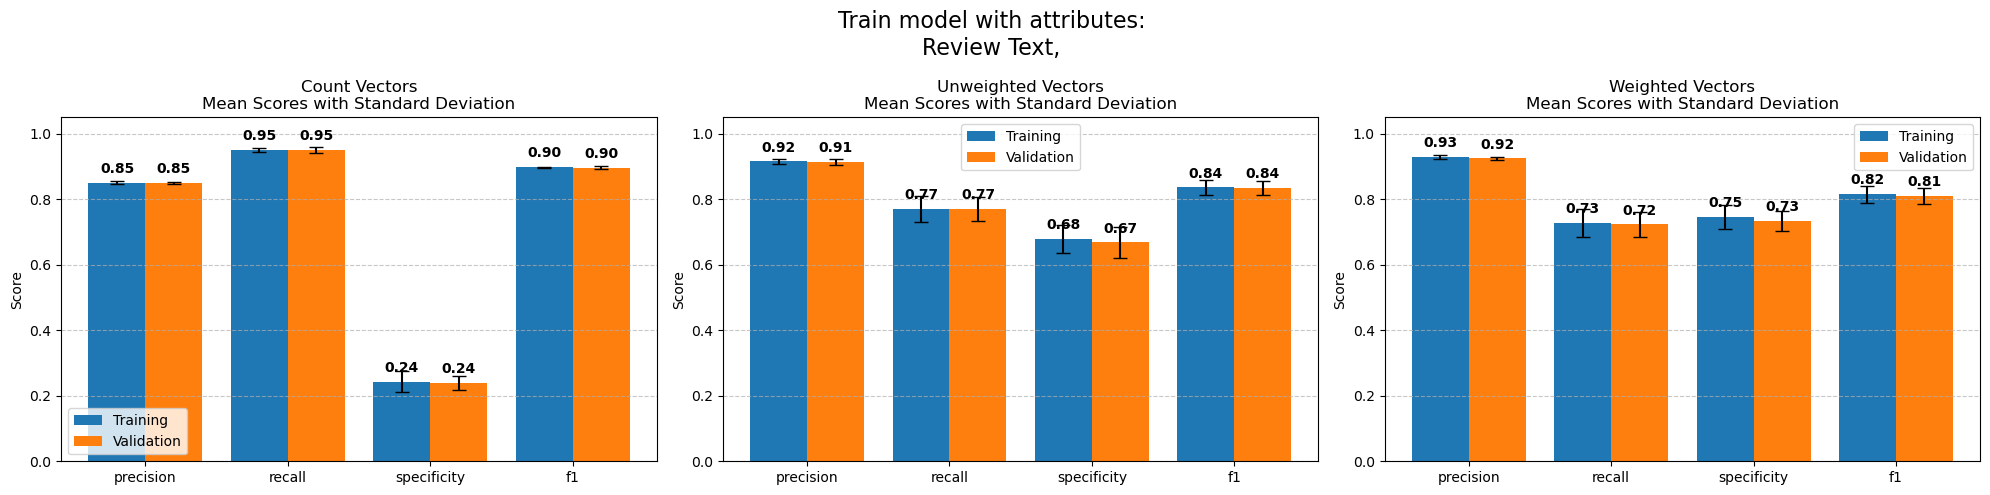

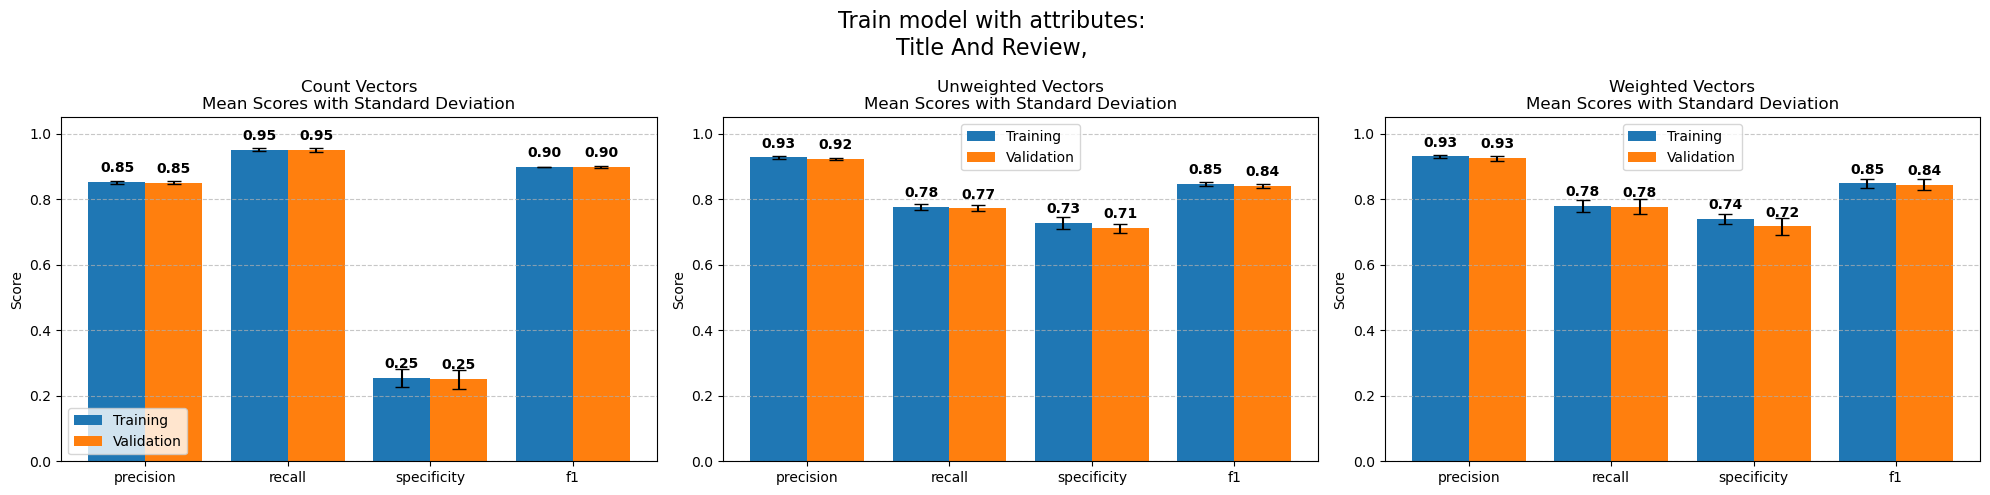

In [36]:
# Train AdaBoost with processed_234

#Train with Title
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title', vocab_title_234, fasttext_234_title_model)
test_model(ada_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Title')

# Train with Review Text
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Review Text', vocab_text_234, fasttext_234_text_model)
test_model(ada_clf, df, count_vectors, unweighted_vectors, weighted_vectors, 'Review Text')

# Train with Title And Review
count_vectors, unweighted_vectors, weighted_vectors = calc_vectors(df_234, 'Title And Review', vocab_both_234, fasttext_234_both_model)
test_model(ada_clf, df_234, count_vectors, unweighted_vectors, weighted_vectors, 'Title And Review')


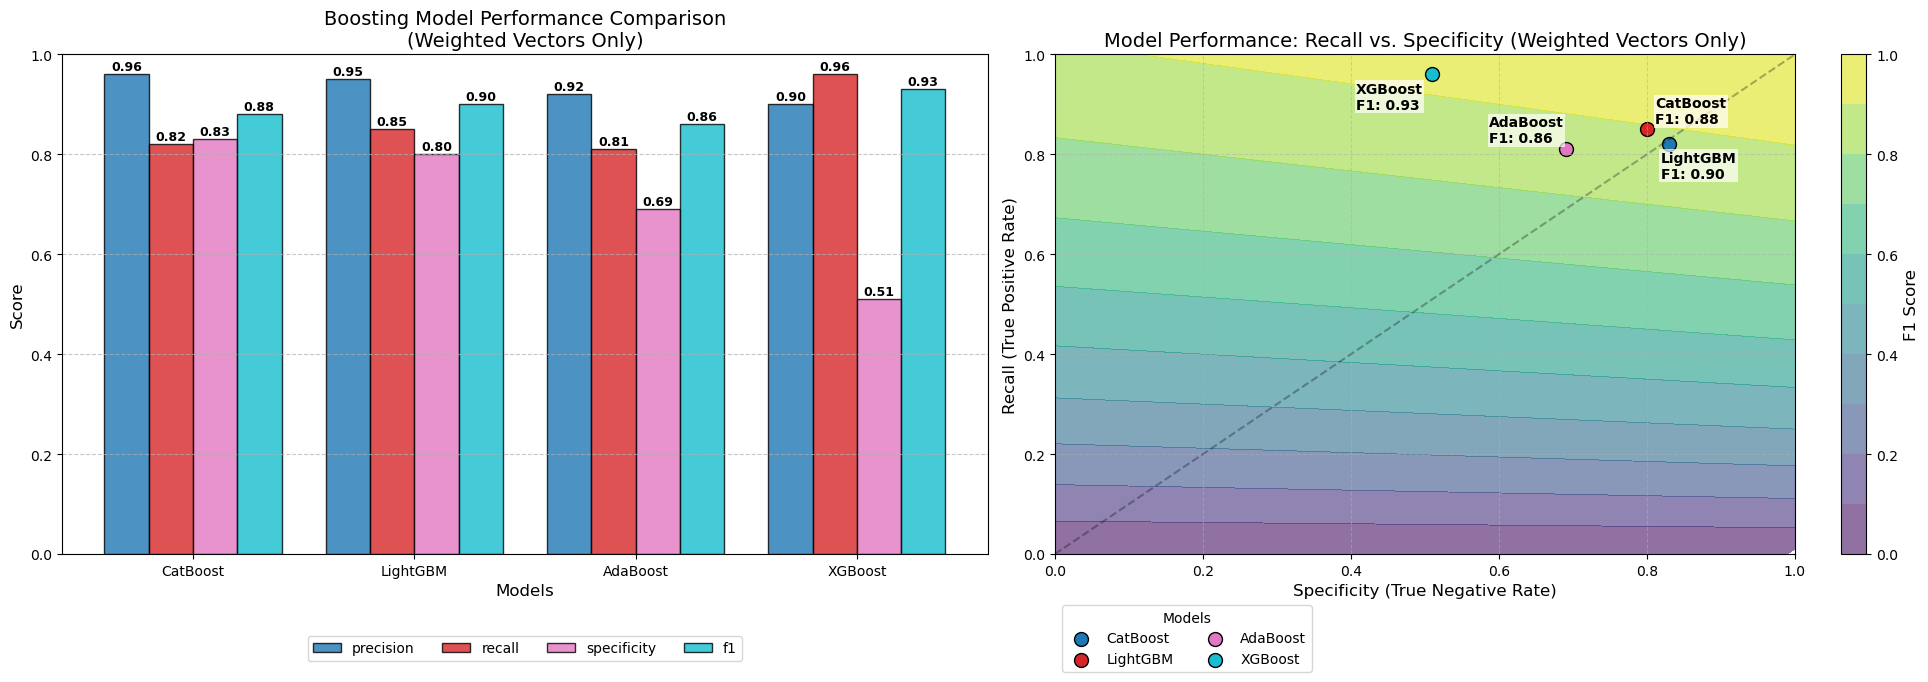

In [37]:
#for model vocab_23 and only both and only validation scores

# Create a clean model comparison visualization
# Create dataframe with model performance data for boosting models only
models_data = [
    # CatBoost with Title And Review
    ["CatBoost", "Weighted", 0.96, 0.82, 0.83, 0.88],
    ["CatBoost", "Unweighted", 0.96, 0.83, 0.83, 0.89],
    ["CatBoost", "Count", 0.93, 0.88, 0.70, 0.90],

    # LightGBM with Title And Review
    ["LightGBM", "Weighted", 0.95, 0.85, 0.80, 0.90],
    ["LightGBM", "Unweighted", 0.95, 0.86, 0.81, 0.90],
    ["LightGBM", "Count", 0.95, 0.84, 0.80, 0.89],

    # AdaBoost with Title And Review
    ["AdaBoost", "Weighted", 0.92, 0.81, 0.69, 0.86],
    ["AdaBoost", "Unweighted", 0.93, 0.77, 0.72, 0.84],
    ["AdaBoost", "Count", 0.85, 0.95, 0.25, 0.90],

    # XGBoost with Title And Review
    ["XGBoost", "Weighted", 0.90, 0.96, 0.51, 0.93],
    ["XGBoost", "Unweighted", 0.90, 0.96, 0.52, 0.93],
    ["XGBoost", "Count", 0.86, 0.98, 0.30, 0.92]
]

df_models = pd.DataFrame(
    models_data,
    columns=["model_name", "vector_type", "precision", "recall", "specificity", "f1"]
)

# Create figures for both visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# === VISUALIZATION 1: BAR CHART FOR MODEL COMPARISON ===
# Select only weighted vectors for the bar chart
weighted_df = df_models[df_models["vector_type"] == "Weighted"].copy()

# Set width of bars
bar_width = 0.2
index = np.arange(len(weighted_df))
metrics = ["precision", "recall", "specificity", "f1"]
colors = plt.cm.tab10(np.linspace(0, 1, len(metrics)))

# Plot grouped bars for each metric
for i, metric in enumerate(metrics):
    offset = bar_width * (i - 1.5)
    bars = ax1.bar(
        index + offset,
        weighted_df[metric],
        bar_width,
        label=metric,
        color=colors[i],
        alpha=0.8,
        edgecolor='black',
        linewidth=1
    )

    # Add value labels above each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax1.annotate(
            f'{height:.2f}',
            xy=(bar.get_x() + bar.get_width()/2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center',
            fontsize=9,
            fontweight='bold'
        )

# Add labels, title and legend
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Boosting Model Performance Comparison\n(Weighted Vectors Only)', fontsize=14)
ax1.set_xticks(index)
ax1.set_xticklabels(weighted_df['model_name'])
ax1.set_ylim(0, 1.0)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# === VISUALIZATION 2: RECALL VS SPECIFICITY WITH F1 CONTOURS ===
# === VISUALIZATION 2: RECALL VS SPECIFICITY WITH F1 CONTOURS ===
# Filter to only show weighted vectors

# === VISUALIZATION 2: RECALL VS SPECIFICITY WITH F1 CONTOURS ===
# Filter to only show weighted vectors
weighted_df = df_models[df_models["vector_type"] == "Weighted"].copy()

# Create a grid of specificity and recall values to calculate F1 contours
specificity_grid = np.linspace(0.0, 1.0, 100)
recall_grid = np.linspace(0.0, 1.0, 100)
specificity_mesh, recall_mesh = np.meshgrid(specificity_grid, recall_grid)

# Define function to calculate precision from specificity and recall
def calculate_precision(specificity, recall, prevalence):
    return (recall * prevalence) / (recall * prevalence + (1 - specificity) * (1 - prevalence))

# Define function to calculate F1 from precision and recall
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-10)  # Add small epsilon to avoid division by zero

# Calculate precision from specificity and recall using Bayes' rule
p = 0.8  # Approximate prevalence of positive class
precision_mesh = calculate_precision(specificity_mesh, recall_mesh, p)
f1_mesh = calculate_f1(precision_mesh, recall_mesh)

# Plot F1 score contours
contour = ax2.contourf(specificity_mesh, recall_mesh, f1_mesh,
                     levels=np.linspace(0.0, 1.0, 11),  # 11 levels gives steps of 0.1
                     cmap='viridis',
                     alpha=0.6)
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label('F1 Score', fontsize=12)

# Plot each model as a scatter point
colors = plt.cm.tab10(np.linspace(0, 1, len(weighted_df)))
for i, (_, row) in enumerate(weighted_df.iterrows()):
    ax2.scatter(row['specificity'], row['recall'],
               s=100,
               c=[colors[i]],
               label=row['model_name'],
               marker='o',
               edgecolor='black',
               linewidth=1)

# Custom annotation positions to avoid overlap
annotation_positions = {
    'CatBoost': (-10, 15),        # above right of point
    'LightGBM': (10, -35),       # below right of point
    'AdaBoost': (-55, 5),      # left of point
    'XGBoost': (-55, -25)      # left and below point
}

# Add model name AND F1 score labels with custom positions to avoid overlap
for i, (_, row) in enumerate(weighted_df.iterrows()):
    model_name = row['model_name']
    position = annotation_positions.get(model_name, (5, 5))  # default position if not specified

    ax2.annotate(f"{model_name}\nF1: {row['f1']:.2f}",
                xy=(row['specificity'], row['recall']),
                xytext=position,
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Configure the plot
ax2.set_xlabel('Specificity (True Negative Rate)', fontsize=12)
ax2.set_ylabel('Recall (True Positive Rate)', fontsize=12)
ax2.set_title('Model Performance: Recall vs. Specificity (Weighted Vectors Only)', fontsize=14)
ax2.set_xlim(0.0, 1.0)
ax2.set_ylim(0.0, 1.0)
ax2.grid(True, linestyle='--', alpha=0.5)

# Add a diagonal line for reference
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)

# Create legend based on the scattered points - positioned outside the plot area
ax2.legend(title="Models", loc='lower left', bbox_to_anchor=(0.0, -0.25), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Make room for the legends
plt.subplots_adjust(bottom=0.2)
plt.show()

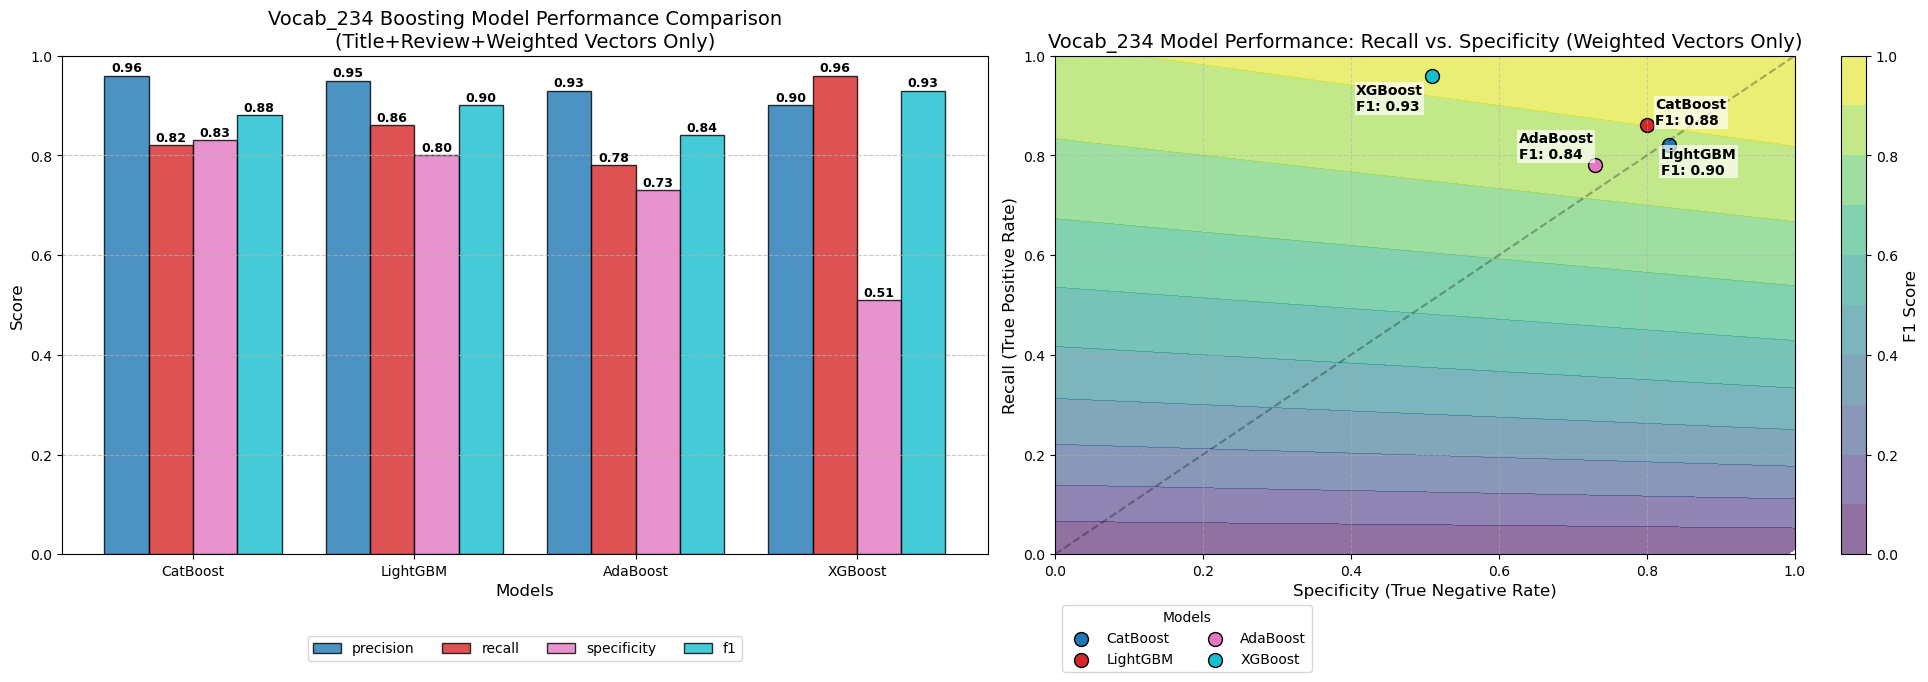

In [38]:
#for model vocab_234 and only both and only validation scores

# Create a clean model comparison visualization
# Create dataframe with model performance data for boosting models only
models_data = [
    # CatBoost with Title And Review
    ["CatBoost", "Weighted", 0.96, 0.82, 0.83, 0.88],
    ["CatBoost", "Unweighted", 0.96, 0.83, 0.83, 0.89],
    ["CatBoost", "Count", 0.93, 0.88, 0.71, 0.90],

    # LightGBM with Title And Review
    ["LightGBM", "Weighted", 0.95, 0.86, 0.80, 0.90],
    ["LightGBM", "Unweighted", 0.95, 0.86, 0.80, 0.90],
    ["LightGBM", "Count", 0.95, 0.84, 0.80, 0.89],

    # AdaBoost with Title And Review
    ["AdaBoost", "Weighted", 0.93, 0.78, 0.73, 0.84],
    ["AdaBoost", "Unweighted", 0.93, 0.79, 0.73, 0.86],
    ["AdaBoost", "Count", 0.85, 0.95, 0.25, 0.90],

    # XGBoost with Title And Review
    ["XGBoost", "Weighted", 0.90, 0.96, 0.51, 0.93],
    ["XGBoost", "Unweighted", 0.90, 0.96, 0.52, 0.93],
    ["XGBoost", "Count", 0.86, 0.98, 0.30, 0.92]
]

df_models = pd.DataFrame(
    models_data,
    columns=["model_name", "vector_type", "precision", "recall", "specificity", "f1"]
)

# Create figures for both visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# === VISUALIZATION 1: BAR CHART FOR MODEL COMPARISON ===
# Select only weighted vectors for the bar chart
weighted_df = df_models[df_models["vector_type"] == "Weighted"].copy()

# Set width of bars
bar_width = 0.2
index = np.arange(len(weighted_df))
metrics = ["precision", "recall", "specificity", "f1"]
colors = plt.cm.tab10(np.linspace(0, 1, len(metrics)))

# Plot grouped bars for each metric
for i, metric in enumerate(metrics):
    offset = bar_width * (i - 1.5)
    bars = ax1.bar(
        index + offset,
        weighted_df[metric],
        bar_width,
        label=metric,
        color=colors[i],
        alpha=0.8,
        edgecolor='black',
        linewidth=1
    )

    # Add value labels above each bar
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax1.annotate(
            f'{height:.2f}',
            xy=(bar.get_x() + bar.get_width()/2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center',
            fontsize=9,
            fontweight='bold'
        )

# Add labels, title and legend
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Vocab_234 Boosting Model Performance Comparison\n(Title+Review+Weighted Vectors Only)', fontsize=14)
ax1.set_xticks(index)
ax1.set_xticklabels(weighted_df['model_name'])
ax1.set_ylim(0, 1.0)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# === VISUALIZATION 2: RECALL VS SPECIFICITY WITH F1 CONTOURS ===
# Filter to only show weighted vectors
weighted_df = df_models[df_models["vector_type"] == "Weighted"].copy()

# Create a grid of specificity and recall values to calculate F1 contours
specificity_grid = np.linspace(0.0, 1.0, 100)
recall_grid = np.linspace(0.0, 1.0, 100)
specificity_mesh, recall_mesh = np.meshgrid(specificity_grid, recall_grid)

# Define function to calculate precision from specificity and recall
def calculate_precision(specificity, recall, prevalence):
    return (recall * prevalence) / (recall * prevalence + (1 - specificity) * (1 - prevalence))

# Define function to calculate F1 from precision and recall
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-10)  # Add small epsilon to avoid division by zero

# Calculate precision from specificity and recall using Bayes' rule
p = 0.8  # Approximate prevalence of positive class
precision_mesh = calculate_precision(specificity_mesh, recall_mesh, p)
f1_mesh = calculate_f1(precision_mesh, recall_mesh)

# Plot F1 score contours
contour = ax2.contourf(specificity_mesh, recall_mesh, f1_mesh,
                     levels=np.linspace(0.0, 1.0, 11),  # 11 levels gives steps of 0.1
                     cmap='viridis',
                     alpha=0.6)
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label('F1 Score', fontsize=12)

# Plot each model as a scatter point
colors = plt.cm.tab10(np.linspace(0, 1, len(weighted_df)))
for i, (_, row) in enumerate(weighted_df.iterrows()):
    ax2.scatter(row['specificity'], row['recall'],
               s=100,
               c=[colors[i]],
               label=row['model_name'],
               marker='o',
               edgecolor='black',
               linewidth=1)

# Custom annotation positions to avoid overlap
annotation_positions = {
    'CatBoost': (-10, 15),        # above right of point
    'LightGBM': (10, -35),       # below right of point
    'AdaBoost': (-55, 5),      # left of point
    'XGBoost': (-55, -25)      # left and below point
}

# Add model name AND F1 score labels with custom positions to avoid overlap
for i, (_, row) in enumerate(weighted_df.iterrows()):
    model_name = row['model_name']
    position = annotation_positions.get(model_name, (5, 5))  # default position if not specified

    ax2.annotate(f"{model_name}\nF1: {row['f1']:.2f}",
                xy=(row['specificity'], row['recall']),
                xytext=position,
                textcoords='offset points',
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Configure the plot
ax2.set_xlabel('Specificity (True Negative Rate)', fontsize=12)
ax2.set_ylabel('Recall (True Positive Rate)', fontsize=12)
ax2.set_title('Vocab_234 Model Performance: Recall vs. Specificity (Weighted Vectors Only)', fontsize=14)
ax2.set_xlim(0.0, 1.0)
ax2.set_ylim(0.0, 1.0)
ax2.grid(True, linestyle='--', alpha=0.5)

# Add a diagonal line for reference
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)

# Create legend based on the scattered points - positioned outside the plot area
ax2.legend(title="Models", loc='lower left', bbox_to_anchor=(0.0, -0.25), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Make room for the legends
plt.subplots_adjust(bottom=0.2)
plt.show()

### References
Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). *Enriching Word Vectors with Subword Information*. Transactions of the Association for Computational Linguistics, 5, 135-146.

Çano, E., & Morisio, M. (2019). *Word Embeddings for Sentiment Analysis: A Comprehensive Empirical Survey.* ArXiv, abs/1902.00753.

Devlin, J., Chang, M., Lee, K., & Toutanova, K. (2019). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.* NAACL-HLT.

Joulin, A., Grave, E., Bojanowski, P., & Mikolov, T. (2016). *Bag of Tricks for Efficient Text Classification.* arXiv preprint arXiv:1607.01759.

Law, T., Shamdasani, J., & Broadbent, T. (2017). *Natural language processing approaches to understanding fashion-related text.* International Conference on AI and Mobile Services.

Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). *Efficient Estimation of Word Representations in Vector Space.* ICLR Workshop Papers.

Mikolov, T., Grave, E., Bojanowski, P., Puhrsch, C., & Joulin, A. (2018). *Advances in Pre-Training Distributed Word Representations.* Proceedings of the International Conference on Language Resources and Evaluation (LREC).

Pennington, J., Socher, R., & Manning, C. D. (2014). *GloVe: Global Vectors for Word Representation.* Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), 1532-1543.

Peters, M., Neumann, M., Iyyer, M., Gardner, M., Clark, C., Lee, K., & Zettlemoyer, L. (2018). *Deep Contextualized Word Representations.* Proceedings of NAACL-HLT.

Rogers, A., Kovaleva, O., & Rumshisky, A. (2020). *A Primer in BERTology: What We Know About How BERT Works.* Transactions of the Association for Computational Linguistics, 8, 842-866.
